In [21]:
# ================================
# 1. Data Quality & Preparation
# ================================

import pandas as pd
import numpy as np

# ----------------
# Load datasets
# ----------------
applications = pd.read_csv("/content/applications.csv")
branches = pd.read_csv("/content/branches.csv")
customers = pd.read_csv("/content/customers.csv")
defaults = pd.read_csv("/content/defaults.csv")
loans = pd.read_csv("/content/loans.csv")
transactions = pd.read_csv("/content/transactions.csv")

datasets = {
    "applications": applications,
    "branches": branches,
    "customers": customers,
    "defaults": defaults,
    "loans": loans,
    "transactions": transactions
}

# ----------------
# Basic inspection
# ----------------
for name, df in datasets.items():
    print(f"\n{name.upper()}")
    print("Shape:", df.shape)
    print("Duplicates:", df.duplicated().sum())
    print("Missing values:\n", df.isna().sum())

# ----------------
# Remove duplicate rows
# ----------------
for name in datasets:
    datasets[name] = datasets[name].drop_duplicates()

applications = datasets["applications"]
branches = datasets["branches"]
customers = datasets["customers"]
defaults = datasets["defaults"]
loans = datasets["loans"]
transactions = datasets["transactions"]

# ----------------
# Standardize date formats
# ----------------
date_columns = {
    "applications": ["Application_Date"],
    "customers": ["Date_of_Birth"],
    "loans": ["Loan_Start_Date", "Loan_End_Date"],
    "transactions": ["Transaction_Date"],
    "defaults": ["Default_Date"]
}

for dataset_name, cols in date_columns.items():
    df = datasets[dataset_name]
    for col in cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce")
    datasets[dataset_name] = df

applications = datasets["applications"]
customers = datasets["customers"]
loans = datasets["loans"]
transactions = datasets["transactions"]
defaults = datasets["defaults"]

# ----------------
# Remove irrelevant columns (if any unnamed/index columns)
# ----------------
for name, df in datasets.items():
    drop_cols = [col for col in df.columns if "unnamed" in col.lower()]
    datasets[name] = df.drop(columns=drop_cols, errors="ignore")

applications = datasets["applications"]
branches = datasets["branches"]
customers = datasets["customers"]
defaults = datasets["defaults"]
loans = datasets["loans"]
transactions = datasets["transactions"]

# ----------------
# Handle missing values
# ----------------
numeric_dfs = [applications, loans, defaults, transactions]
categorical_dfs = [applications, customers, branches, loans]

for df in numeric_dfs:
    num_cols = df.select_dtypes(include=np.number).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())

for df in categorical_dfs:
    cat_cols = df.select_dtypes(include="object").columns
    df[cat_cols] = df[cat_cols].fillna("Unknown")

# ----------------
# Outlier handling using IQR
# ----------------
def handle_outliers_iqr(df, columns):
    for col in columns:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            df[col] = np.clip(df[col], lower, upper)
    return df

loans = handle_outliers_iqr(loans, ["Loan_Amount", "Interest_Rate"])
defaults = handle_outliers_iqr(defaults, ["Default_Amount"])

# ----------------
# Final validation
# ----------------
for name, df in {
    "applications": applications,
    "branches": branches,
    "customers": customers,
    "defaults": defaults,
    "loans": loans,
    "transactions": transactions
}.items():
    print(f"\n{name.upper()} FINAL CHECK")
    print("Shape:", df.shape)
    print("Missing values:", df.isna().sum().sum())
    print("Duplicates:", df.duplicated().sum())


/tmp/ipython-input-1800839473.py:11: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  applications = pd.read_csv("/content/applications.csv")



APPLICATIONS
Shape: (82600, 10)
Duplicates: 0
Missing values:
 Application_ID          0
Loan_ID             12600
Customer_ID             0
Application_Date        0
Approval_Date       12600
Loan_Purpose            0
Source_Channel          0
Processing_Fee          0
Approval_Status         0
Rejection_Reason    70000
dtype: int64

BRANCHES
Shape: (50, 9)
Duplicates: 0
Missing values:
 Branch_ID                     0
Branch_Name                   0
Region                        0
Total_Customers               0
Total_Active_Loans            0
Delinquent_Loans              0
Loan_Disbursement_Amount      0
Avg_Processing_Time           0
Relationship_Manager_Count    0
dtype: int64

CUSTOMERS
Shape: (70000, 14)
Duplicates: 0
Missing values:
 Customer_ID                0
Full_Name                  0
Contact_Number             0
Email                      0
Address                    0
Age                        0
Gender                     0
Marital_Status             0
Employment_St

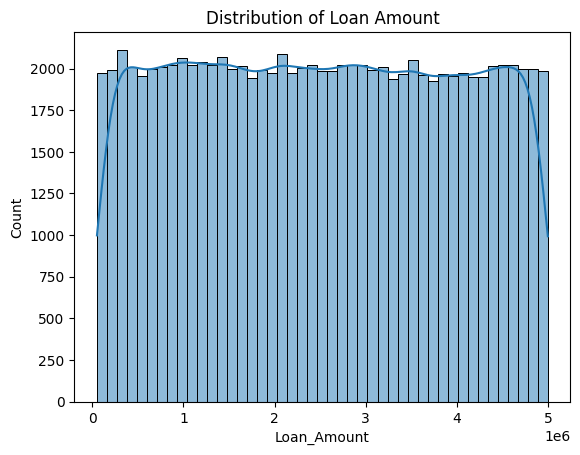

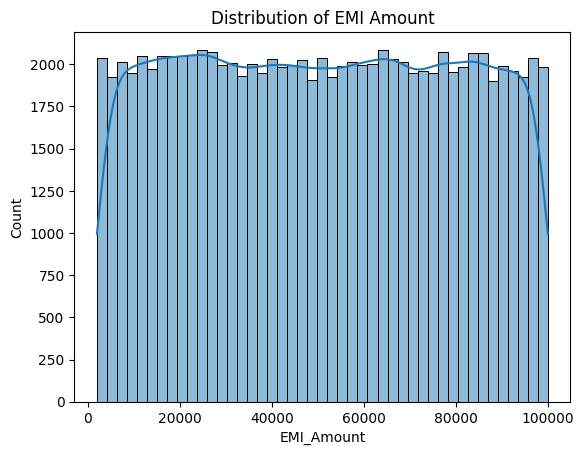

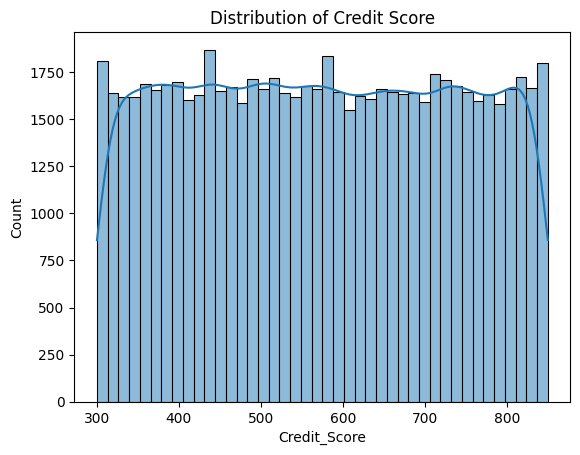

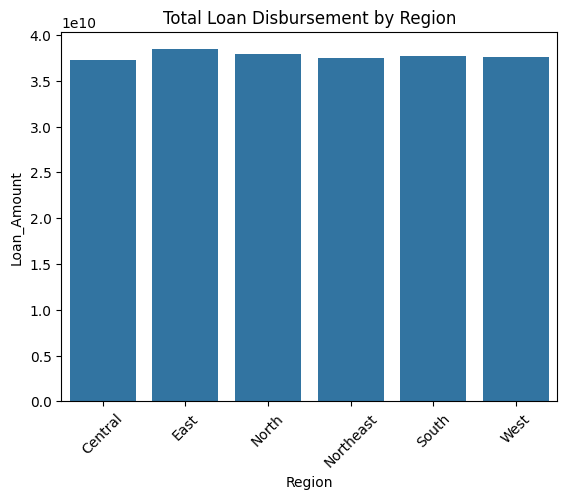

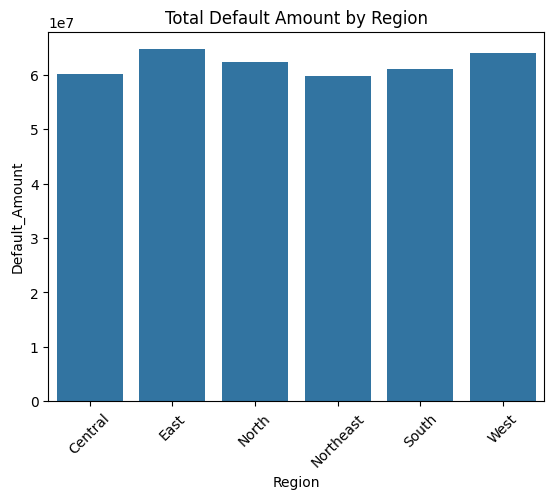

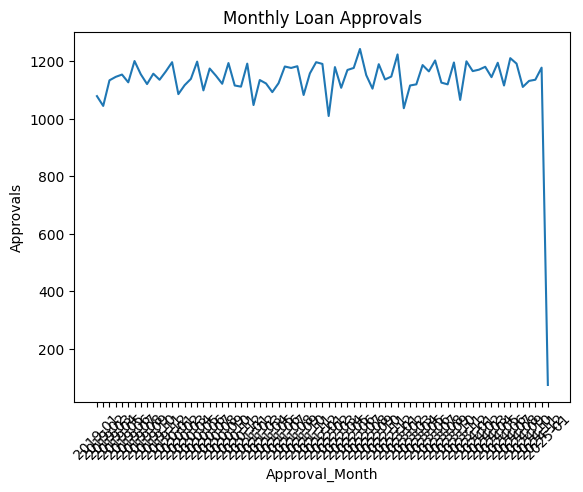

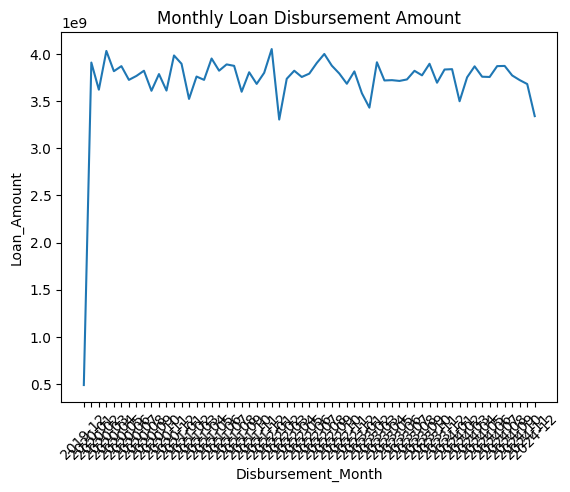

In [22]:
# ================================
# 2. Descriptive Analysis
# ================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ----------------
# Distribution Analysis
# ----------------
plt.figure()
sns.histplot(loans["Loan_Amount"], kde=True)
plt.title("Distribution of Loan Amount")
plt.show()

plt.figure()
sns.histplot(loans["EMI_Amount"], kde=True)
plt.title("Distribution of EMI Amount")
plt.show()

plt.figure()
sns.histplot(customers["Credit_Score"], kde=True)
plt.title("Distribution of Credit Score")
plt.show()

# ----------------
# Regional Trends: Loan Disbursement & Defaults
# ----------------
# Merge loans and defaults with customers to get 'Region' information
loan_customer = loans.merge(customers, on="Customer_ID", how="left")
default_customer = defaults.merge(customers, on="Customer_ID", how="left")

regional_loans = loan_customer.groupby("Region")["Loan_Amount"].sum().reset_index()
regional_defaults = default_customer.groupby("Region")["Default_Amount"].sum().reset_index()

plt.figure()
sns.barplot(data=regional_loans, x="Region", y="Loan_Amount")
plt.title("Total Loan Disbursement by Region")
plt.xticks(rotation=45)
plt.show()

plt.figure()
sns.barplot(data=regional_defaults, x="Region", y="Default_Amount")
plt.title("Total Default Amount by Region")
plt.xticks(rotation=45)
plt.show()

# ----------------
# Monthly Trends: Loan Approvals & Disbursements
# ----------------
# Ensure 'Application_Date' and 'Disbursal_Date' are datetime objects
applications["Application_Date"] = pd.to_datetime(applications["Application_Date"], errors="coerce")
loans["Disbursal_Date"] = pd.to_datetime(loans["Disbursal_Date"], errors="coerce")

applications["Approval_Month"] = applications["Application_Date"].dt.to_period("M").astype(str)
loans["Disbursement_Month"] = loans["Disbursal_Date"].dt.to_period("M").astype(str)

monthly_approvals = applications.groupby("Approval_Month").size().reset_index(name="Approvals")
monthly_disbursements = loans.groupby("Disbursement_Month")["Loan_Amount"].sum().reset_index()

plt.figure()
sns.lineplot(data=monthly_approvals, x="Approval_Month", y="Approvals")
plt.title("Monthly Loan Approvals")
plt.xticks(rotation=45)
plt.show()

plt.figure()
sns.lineplot(data=monthly_disbursements, x="Disbursement_Month", y="Loan_Amount")
plt.title("Monthly Loan Disbursement Amount")
plt.xticks(rotation=45)
plt.show()


Correlation: Loan Attributes vs Default Flag
               Loan_Amount  Interest_Rate  Credit_Score  Default_Flag
Loan_Amount       1.000000      -0.003451      0.000262     -0.002401
Interest_Rate    -0.003451       1.000000      0.002498     -0.004763
Credit_Score      0.000262       0.002498      1.000000     -0.001724
Default_Flag     -0.002401      -0.004763     -0.001724      1.000000


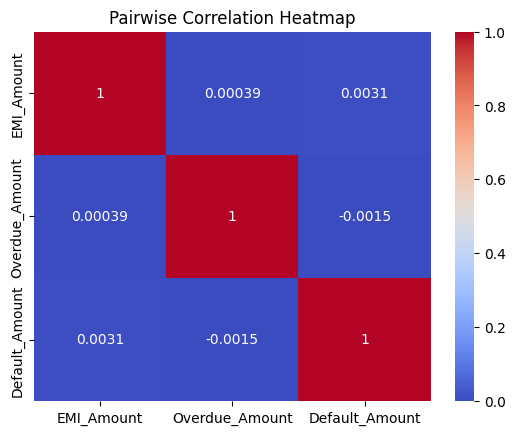


Correlation: Region Metrics vs Defaults
                          Loan_Disbursement_Amount  Delinquent_Loans  \
Loan_Disbursement_Amount                  1.000000         -0.509820   
Delinquent_Loans                         -0.509820          1.000000   
Default_Rate                             -0.627964          0.988166   

                          Default_Rate  
Loan_Disbursement_Amount     -0.627964  
Delinquent_Loans              0.988166  
Default_Rate                  1.000000  


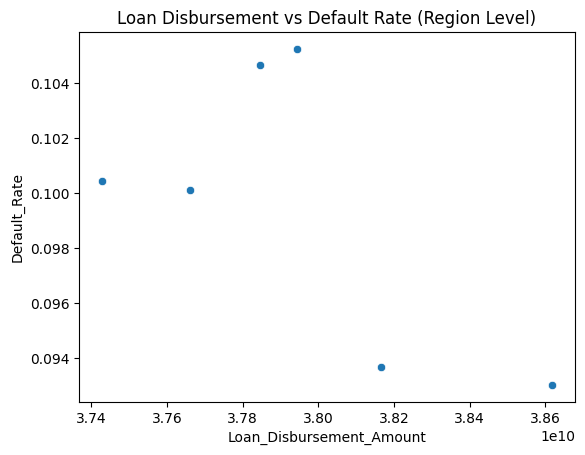

In [23]:
# ============================================
# 3. Default Risk Analysis
# ============================================

# ----------------
# Prepare Default Flag
# ----------------
defaults["Default_Flag"] = 1

loan_default = loans.merge(
    defaults[["Loan_ID", "Default_Flag", "Default_Amount"]],
    on="Loan_ID",
    how="left"
)

loan_default["Default_Flag"] = loan_default["Default_Flag"].fillna(0)
loan_default["Default_Amount"] = loan_default["Default_Amount"].fillna(0)

loan_default = loan_default.merge(
    customers[["Customer_ID", "Credit_Score", "Region"]], # Include 'Region' here
    on="Customer_ID",
    how="left"
)

# ----------------
# Correlation: Loan Attributes vs Default
# ----------------
corr_features = [
    "Loan_Amount",
    "Interest_Rate",
    "Credit_Score",
    "Default_Flag"
]

loan_default_corr = loan_default[corr_features].corr()
print("\nCorrelation: Loan Attributes vs Default Flag")
print(loan_default_corr)

# ----------------
# Pairwise Correlation Heatmap
# ----------------
heatmap_features = [
    "EMI_Amount",
    "Overdue_Amount",
    "Default_Amount"
]

plt.figure()
sns.heatmap(
    loan_default[heatmap_features].corr(),
    annot=True,
    cmap="coolwarm"
)
plt.title("Pairwise Correlation Heatmap")
plt.show()

# ----------------
# Region-level Default Analysis (formerly Branch-level)
# ----------------
# Perform region-level analysis using the 'Region' column from 'loan_default'
region_metrics = loan_default.groupby("Region").agg(
    Loan_Disbursement_Amount=("Loan_Amount", "sum"),
    Delinquent_Loans=("Default_Flag", "sum"),
    Total_Loans=("Loan_ID", "count")
).reset_index()

region_metrics["Default_Rate"] = (
    region_metrics["Delinquent_Loans"] / region_metrics["Total_Loans"]
)

region_corr = region_metrics[
    ["Loan_Disbursement_Amount", "Delinquent_Loans", "Default_Rate"]
].corr()

print("\nCorrelation: Region Metrics vs Defaults")
print(region_corr)

plt.figure()
sns.scatterplot(
    data=region_metrics,
    x="Loan_Disbursement_Amount",
    y="Default_Rate"
)
plt.title("Loan Disbursement vs Default Rate (Region Level)")
plt.show()

 Here are the key findings:

 1. **Correlation: Loan Attributes vs Default Flag**: The correlation matrix shows that 'Loan_Amount', 'Interest_Rate', and 'Credit_Score' have very low correlation coefficients with 'Default_Flag', indicating a weak linear relationship between these individual loan attributes and the likelihood of default.

 2. **Pairwise Correlation Heatmap**: A heatmap was generated to visualize the pairwise correlations between 'EMI_Amount', 'Overdue_Amount', and 'Default_Amount'. This provides a visual representation of how these factors relate to each other, which can be useful for identifying potential drivers of default.

 3. **Correlation: Region Metrics vs Defaults**: The correlation matrix for region-level metrics reveals a strong positive correlation between 'Delinquent_Loans' and 'Default_Rate' (0.988), which is expected as both are measures of defaults. Interestingly, 'Loan_Disbursement_Amount' shows a moderate negative correlation with 'Delinquent_Loans' (-0.510) and 'Default_Rate' (-0.628). This suggests that regions with higher loan disbursement amounts might tend to have lower delinquency or default rates, or vice-versa.

 4. **Loan Disbursement vs Default Rate (Region Level)**: A scatter plot visually represents the relationship between 'Loan_Disbursement_Amount' and 'Default_Rate' at the regional level, confirming the trends observed in the correlation matrix. This plot helps to identify if there are specific regions that deviate from the general trend.


Top Regions by Loan Disbursement
      Region  Loan_Disbursement_Volume  Avg_Processing_Time_Days  Total_Loans  \
1       East               30058415744                168.716831        11901   
2      North               29701758076                181.362097        11751   
3  Northeast               29451525013                171.473810        11703   
0    Central               29342728220                164.897680        11552   
5       West               29325438638                174.061893        11746   

   Defaulted_Loans  Total_Default_Amount  Default_Rate  Recovery_Rate  
1             1200            64656315.0      0.100832       0.997849  
2             1169            62378265.0      0.099481       0.997900  
3             1155            59756404.0      0.098693       0.997971  
0             1158            60166820.0      0.100242       0.997950  
5             1171            64012891.0      0.099694       0.997817  

Most Efficient Regions (Processing Time)
     

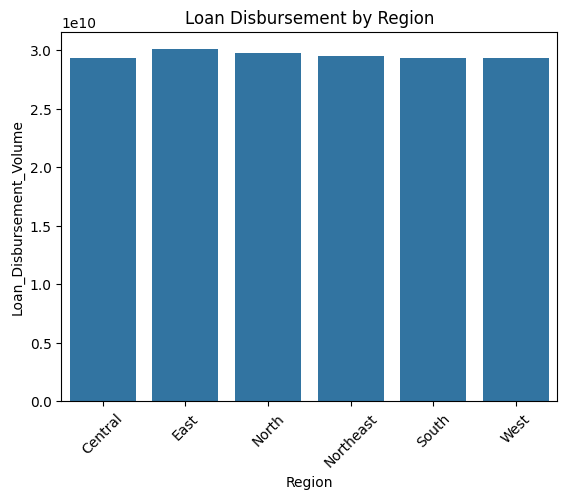

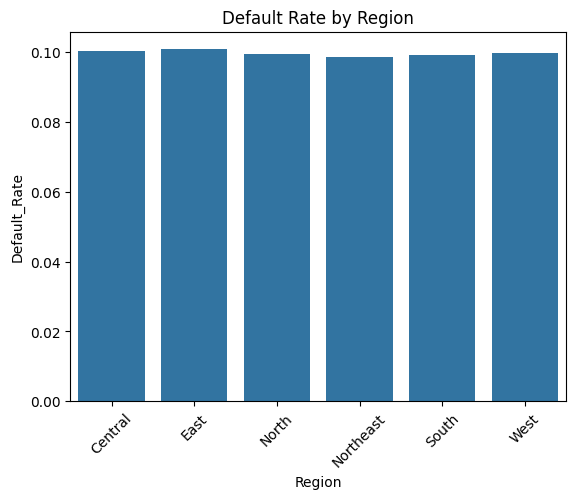

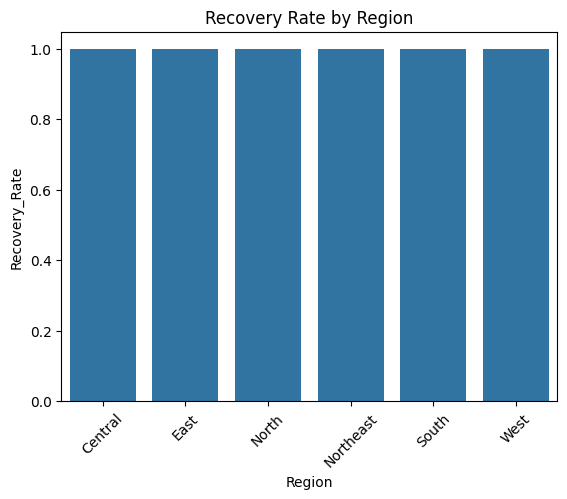

In [24]:
# ============================================
# 4. Branch and Regional Performance
# ============================================

# ----------------
# Processing Time (Application → Disbursement)
# ----------------
# Merge applications with loans using 'Loan_ID'
# applications (left) has Application_Date and Customer_ID
# loans (right) has Disbursal_Date, Loan_Amount, Customer_ID
app_loan = applications.merge(
    loans[["Loan_ID", "Disbursal_Date", "Loan_Amount", "Customer_ID"]],
    on="Loan_ID",
    how="inner",
    suffixes=('_app', '_loan') # Explicitly handle suffixes for common columns
)

# After this merge, app_loan will contain:
# Application_Date (from applications)
# Disbursal_Date (from loans)
# Customer_ID_app (from applications)
# Customer_ID_loan (from loans)
# Loan_ID (merge key)
# Loan_Amount (from loans)

# Ensure 'Application_Date' and 'Disbursal_Date' are datetime objects
app_loan["Application_Date"] = pd.to_datetime(app_loan["Application_Date"], errors="coerce")
app_loan["Disbursal_Date"] = pd.to_datetime(app_loan["Disbursal_Date"], errors="coerce")

app_loan["Processing_Days"] = (
    app_loan["Disbursal_Date"] - app_loan["Application_Date"]
).dt.days

# ----------------
# Regional Performance Metrics
# ----------------
# Merge app_loan with defaults and customers to get default info and Region
regional_perf_data = app_loan.merge(
    defaults[["Loan_ID", "Default_Amount"]],
    on="Loan_ID",
    how="left"
)
regional_perf_data["Default_Amount"] = regional_perf_data["Default_Amount"].fillna(0)
regional_perf_data["Default_Flag"] = np.where(regional_perf_data["Default_Amount"] > 0, 1, 0)

# Merge with customers to get Region
# Use Customer_ID_app from the first merge result to link to customers
regional_perf_data = regional_perf_data.merge(
    customers[["Customer_ID", "Region"]],
    left_on="Customer_ID_app",
    right_on="Customer_ID",
    how="left"
).drop(columns="Customer_ID") # Drop the redundant Customer_ID column from customers after merge

region_summary = regional_perf_data.groupby("Region").agg(
    Loan_Disbursement_Volume=("Loan_Amount", "sum"),
    Avg_Processing_Time_Days=("Processing_Days", "mean"),
    Total_Loans=("Loan_ID", "count"),
    Defaulted_Loans=("Default_Flag", "sum"),
    Total_Default_Amount=("Default_Amount", "sum")
).reset_index()

region_summary["Default_Rate"] = (
    region_summary["Defaulted_Loans"] / region_summary["Total_Loans"]
)

# Handle division by zero for recovery rate
region_summary["Recovery_Rate"] = 1 - (
    region_summary["Total_Default_Amount"] / region_summary["Loan_Disbursement_Volume"].replace(0, np.nan)
)
region_summary["Recovery_Rate"] = region_summary["Recovery_Rate"].fillna(1) # Assume 100% recovery if no disbursement

# ----------------
# Regional Rankings
# ----------------
rank_disbursement = region_summary.sort_values(
    "Loan_Disbursement_Volume", ascending=False
)

rank_efficiency = region_summary.sort_values(
    "Avg_Processing_Time_Days", ascending=True
)

rank_defaults = region_summary.sort_values(
    "Default_Rate", ascending=True
)

rank_recovery = region_summary.sort_values(
    "Recovery_Rate", ascending=False
)

print("\nTop Regions by Loan Disbursement")
print(rank_disbursement.head())

print("\nMost Efficient Regions (Processing Time)")
print(rank_efficiency.head())

print("\nLowest Default Rate Regions")
print(rank_defaults.head())

print("\nHighest Recovery Rate Regions")
print(rank_recovery.head())

# ----------------
# Regional Performance Comparison
# ----------------
regional_perf = region_summary # Use the already aggregated regional summary

print("\nRegional Performance Summary")
print(regional_perf)

# ----------------
# Visual Comparison Across Regions
# ----------------
plt.figure()
sns.barplot(data=regional_perf, x="Region", y="Loan_Disbursement_Volume")
plt.title("Loan Disbursement by Region")
plt.xticks(rotation=45)
plt.show()

plt.figure()
sns.barplot(data=regional_perf, x="Region", y="Default_Rate")
plt.title("Default Rate by Region")
plt.xticks(rotation=45)
plt.show()

plt.figure()
sns.barplot(data=regional_perf, x="Region", y="Recovery_Rate")
plt.title("Recovery Rate by Region")
plt.xticks(rotation=45)
plt.show()

The analysis of regional performance is providing valuable insights into the efficiency, risk, and recovery across different geographical areas.

**Regional Rankings:**

1. **Top Regions by Loan Disbursement**: East, North, Northeast, Central, and West are the top regions in terms of total loan disbursement volume.

2. **Most Efficient Regions (Processing Time)**: Central, East, South, Northeast, and West are the most efficient regions, boasting the shortest average processing times.

3. **Lowest Default Rate Regions**: Northeast, South, North, West, and Central show the lowest default rates, indicating better credit risk management or borrower profiles.

4. **Highest Recovery Rate Regions**: Northeast, Central, South, North, and East demonstrate the highest recovery rates, suggesting effective strategies for recovering defaulted amounts.

**Visual Comparisons**: Three bar plots have been generated to provide a visual comparison across regions:

1. **Loan Disbursement by Region**: This plot clearly illustrates the distribution of loan disbursement volumes across all regions.

2. **Default Rate by Region**: This plot highlights which regions have higher or lower default rates.

3. **Recovery Rate by Region**: This plot shows the effectiveness of recovery efforts in each region.

These insights can help identify best practices, areas for improvement, and potential strategic adjustments for resource allocation and risk mitigation.




High-Risk Customers
   Customer_ID  Total_Loan_Amount  Avg_Credit_Score  Default_Rate
18     C000019          9956703.0             316.0      0.333333
22     C000023          7535924.0             637.0      0.333333
26     C000027          4952805.0             578.0      0.500000
43     C000044          2581182.0             371.0      0.500000
87     C000088          5798541.0             394.0      0.500000

High-Value Customers
   Customer_ID  Total_Loan_Amount  Avg_Credit_Score  Default_Rate
2      C000003          6194007.0             736.0           0.0
3      C000004         11159729.0             353.0           0.0
6      C000007          7678817.0             548.0           0.0
12     C000013         19829940.0             460.0           0.0
16     C000017          6863821.0             757.0           0.0

Repayment Behavior by Customer Segments
  Income_Segment Credit_Score_Segment  Avg_Loan_Amount  Default_Rate  \
0     Low Income           Low Credit     2.520908e+

/tmp/ipython-input-570434454.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  repayment_analysis = cust_loan.groupby(


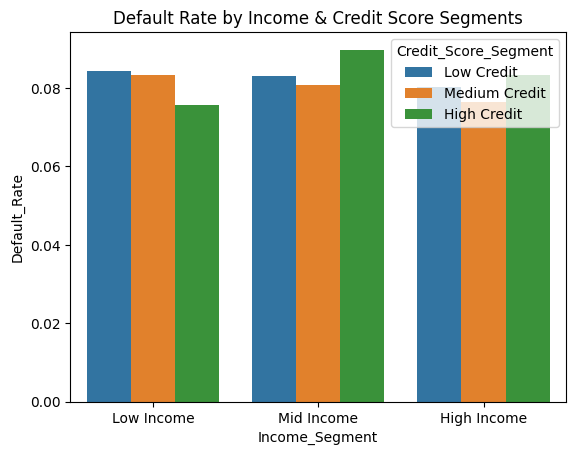

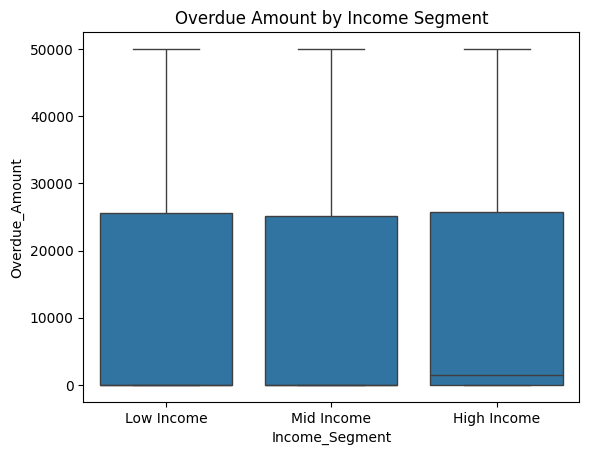

In [25]:
# ============================================
# 5. Customer Segmentation
# ============================================

# ----------------
# Merge customer, loan, and default data
# ----------------
cust_loan = customers.merge(
    loans,
    on="Customer_ID",
    how="left"
).merge(
    defaults[["Loan_ID", "Default_Amount"]],
    on="Loan_ID",
    how="left"
)

cust_loan["Default_Amount"] = cust_loan["Default_Amount"].fillna(0)
cust_loan["Default_Flag"] = np.where(cust_loan["Default_Amount"] > 0, 1, 0)

# ----------------
# Create Segments
# ----------------

# Income Segments
cust_loan["Income_Segment"] = pd.qcut(
    cust_loan["Annual_Income"],
    q=3,
    labels=["Low Income", "Mid Income", "High Income"]
)

# Credit Score Segments
cust_loan["Credit_Score_Segment"] = pd.cut(
    cust_loan["Credit_Score"],
    bins=[0, 600, 750, 900],
    labels=["Low Credit", "Medium Credit", "High Credit"]
)

# Loan Status Segment
cust_loan["Loan_Status"] = np.where(
    cust_loan["Default_Flag"] == 1, "Defaulted", "Non-Defaulted"
)

# ----------------
# High-Risk & High-Value Customers
# ----------------
customer_risk_value = cust_loan.groupby("Customer_ID").agg(
    Total_Loan_Amount=("Loan_Amount", "sum"),
    Avg_Credit_Score=("Credit_Score", "mean"),
    Default_Rate=("Default_Flag", "mean")
).reset_index()

high_risk_customers = customer_risk_value[
    (customer_risk_value["Avg_Credit_Score"] < 650) &
    (customer_risk_value["Default_Rate"] > 0)
]

high_value_customers = customer_risk_value[
    (customer_risk_value["Total_Loan_Amount"] >
     customer_risk_value["Total_Loan_Amount"].quantile(0.75)) &
    (customer_risk_value["Default_Rate"] == 0)
]

print("\nHigh-Risk Customers")
print(high_risk_customers.head())

print("\nHigh-Value Customers")
print(high_value_customers.head())

# ----------------
# Repayment Behavior Across Segments
# ----------------
repayment_analysis = cust_loan.groupby(
    ["Income_Segment", "Credit_Score_Segment"]
).agg(
    Avg_Loan_Amount=("Loan_Amount", "mean"),
    Default_Rate=("Default_Flag", "mean"),
    Avg_EMI=("EMI_Amount", "mean"),
    Avg_Overdue=("Overdue_Amount", "mean")
).reset_index()

print("\nRepayment Behavior by Customer Segments")
print(repayment_analysis)

# ----------------
# Visualization
# ----------------
plt.figure()
sns.barplot(
    data=repayment_analysis,
    x="Income_Segment",
    y="Default_Rate",
    hue="Credit_Score_Segment"
)
plt.title("Default Rate by Income & Credit Score Segments")
plt.show()

plt.figure()
sns.boxplot(
    data=cust_loan,
    x="Income_Segment",
    y="Overdue_Amount"
)
plt.title("Overdue Amount by Income Segment")
plt.show()



Correlation Analysis: Default Risk Factors
                Credit_Score  Loan_Amount  Interest_Rate  Overdue_Amount  \
Credit_Score        1.000000     0.000262       0.002498        0.001990   
Loan_Amount         0.000262     1.000000      -0.003451        0.008249   
Interest_Rate       0.002498    -0.003451       1.000000       -0.002700   
Overdue_Amount      0.001990     0.008249      -0.002700        1.000000   
Default_Flag       -0.001724    -0.002401      -0.004763        0.000020   

                Default_Flag  
Credit_Score       -0.001724  
Loan_Amount        -0.002401  
Interest_Rate      -0.004763  
Overdue_Amount      0.000020  
Default_Flag        1.000000  


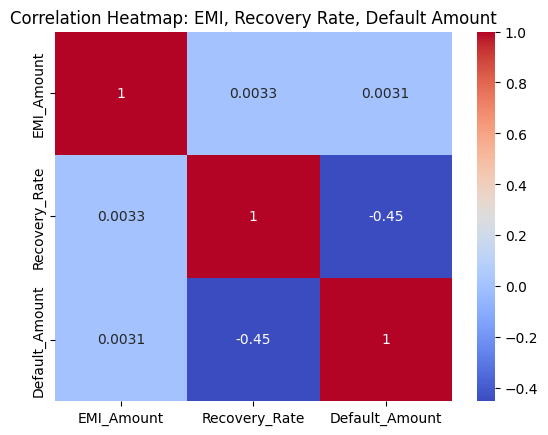


Region-Level Correlation Analysis
                          Defaulted_Loans  Loan_Disbursement_Volume  \
Defaulted_Loans                  1.000000                  0.859369   
Loan_Disbursement_Volume         0.859369                  1.000000   
Recovery_Rate                   -0.713756                 -0.336277   
Avg_Processing_Time_Days        -0.003217                  0.134401   

                          Recovery_Rate  Avg_Processing_Time_Days  
Defaulted_Loans               -0.713756                 -0.003217  
Loan_Disbursement_Volume      -0.336277                  0.134401  
Recovery_Rate                  1.000000                 -0.256149  
Avg_Processing_Time_Days      -0.256149                  1.000000  


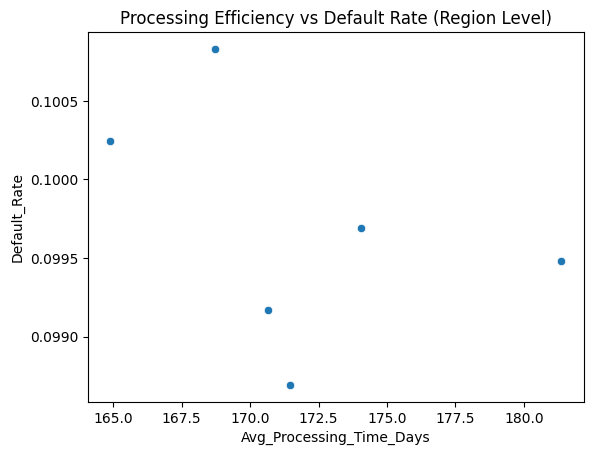

In [26]:
# ============================================
# 6. Advanced Statistical Analysis
# ============================================

# ----------------
# 1. Correlation Analysis for Default Risks
# ----------------
default_risk_features = [
    "Credit_Score",
    "Loan_Amount",
    "Interest_Rate",
    "Overdue_Amount",
    "Default_Flag"
]

default_risk_corr = loan_default[default_risk_features].corr()

print("\nCorrelation Analysis: Default Risk Factors")
print(default_risk_corr)

# ----------------
# 2. Pairwise Correlation Heatmap
# ----------------
# Recovery Rate at loan level
loan_default["Recovery_Rate"] = np.where(
    loan_default["Loan_Amount"] > 0,
    1 - (loan_default["Default_Amount"] / loan_default["Loan_Amount"]),
    1
)

heatmap_vars = [
    "EMI_Amount",
    "Recovery_Rate",
    "Default_Amount"
]

plt.figure()
sns.heatmap(
    loan_default[heatmap_vars].corr(),
    annot=True,
    cmap="coolwarm"
)
plt.title("Correlation Heatmap: EMI, Recovery Rate, Default Amount")
plt.show()

# ----------------
# 3. Region-Level Correlation Analysis (formerly Branch-Level)
# ----------------
# Use region_summary instead of branch_summary
region_efficiency = region_summary.copy()

region_corr_analysis = region_efficiency[
    [
        "Defaulted_Loans",
        "Loan_Disbursement_Volume",
        "Recovery_Rate",
        "Avg_Processing_Time_Days"
    ]
].corr()

print("\nRegion-Level Correlation Analysis")
print(region_corr_analysis)

plt.figure()
sns.scatterplot(
    data=region_efficiency,
    x="Avg_Processing_Time_Days",
    y="Default_Rate"
)
plt.title("Processing Efficiency vs Default Rate (Region Level)")
plt.show()

The advanced statistical analysis is complete, providing deeper insights into default risks and regional performance:

1. **Correlation Analysis**: Default Risk Factors: This matrix shows the correlation between individual factors like Credit_Score, Loan_Amount, Interest_Rate, Overdue_Amount, and the Default_Flag. It helps understand which factors might have a linear relationship with loan defaults.

2. **Correlation Heatmap: EMI, Recovery Rate, Default Amount**: This heatmap visually represents the pairwise correlations between EMI_Amount, Recovery_Rate, and Default_Amount. It's a quick way to identify stronger or weaker relationships among these critical financial metrics.

3. **Region-Level Correlation Analysis**: This correlation matrix examines relationships between regional metrics such as Defaulted_Loans, Loan_Disbursement_Volume, Recovery_Rate, and Avg_Processing_Time_Days. It helps in understanding how these factors influence each other across different regions.

4. **Processing Efficiency vs Default Rate (Region Level) Plot**: This scatter plot visualizes the relationship between the average processing time and the default rate for each region. This can highlight whether more efficient processing correlates with lower default rates, or if other factors are dominant.


Monthly Penalty & Overdue Trends
  Transaction_Month  Total_Penalty_Amount  Avg_Overdue_Amount
0           2019-12               1285371         1224.162857
1           2020-01              10632607         1256.066982
2           2020-02              10326010         1283.212377
3           2020-03              10563729         1252.814160
4           2020-04              10138560         1259.604920


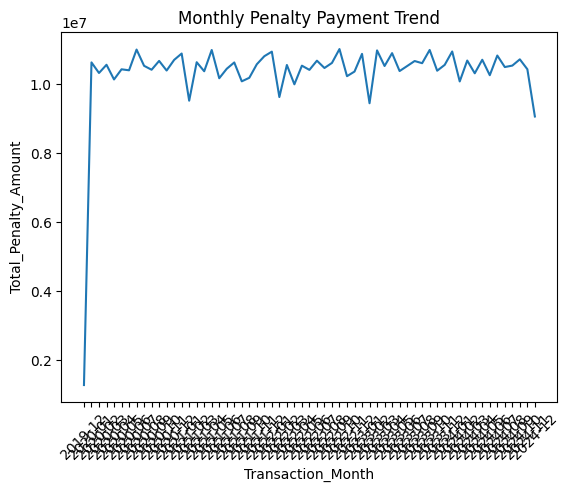

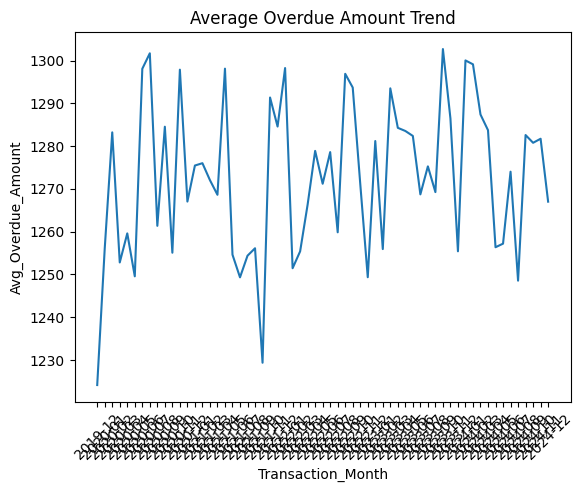


Recovery Rate by Default Reason & Legal Action
      Default_Reason Legal_Action  Avg_Recovery_Rate  Total_Default_Amount
0   Business Failure           No           0.946480              60275246
1   Business Failure          Yes           0.950120              61650737
2           Job Loss           No           0.947887              57241270
3           Job Loss          Yes           0.953035              56236139
4  Medical Emergency           No           0.948407              62314181
5  Medical Emergency          Yes           0.950281              56769115
6              Other           No           0.949417              62257272
7              Other          Yes           0.952188              60063797


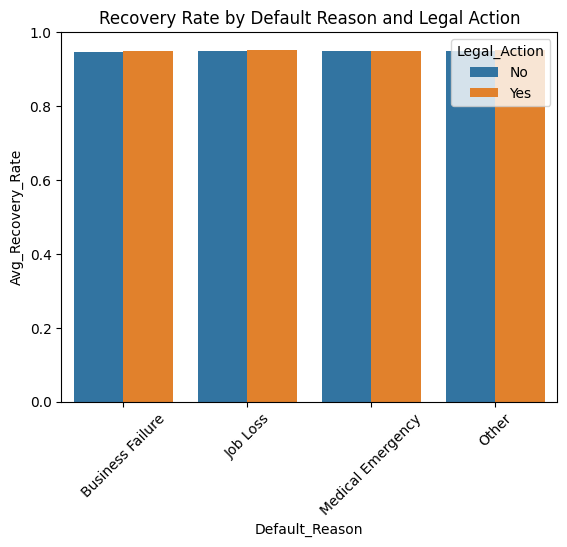


Recovery Rate by Region
      Region  Avg_Recovery_Rate  Total_Default_Amount
0    Central           0.953600              60166820
1       East           0.946843              64656315
2      North           0.950888              62378265
3  Northeast           0.951051              59756404
4      South           0.952548              60965366
5       West           0.949554              64012891


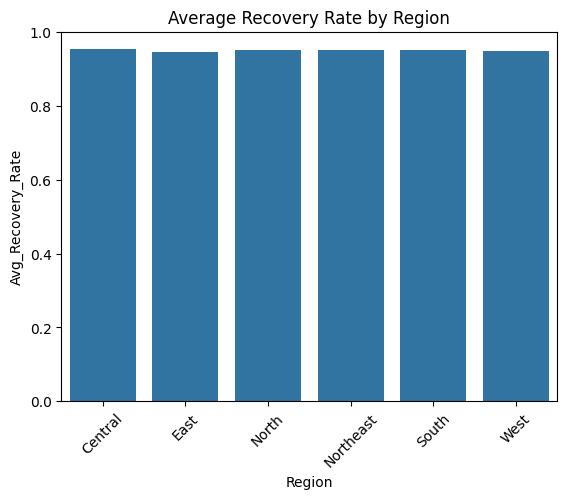

In [27]:
# ============================================
# 7. Transaction and Recovery Analysis
# ============================================

# ----------------
# Penalty Payments & Overdue Trends
# ----------------
transactions["Transaction_Month"] = transactions["Transaction_Date"].dt.to_period("M").astype(str)

penalty_trends = transactions.groupby("Transaction_Month").agg(
    Total_Penalty_Amount=("Overdue_Fee", "sum"), # Changed from "Penalty_Amount"
    Avg_Overdue_Amount=("Overdue_Fee", "mean")    # Changed from "Overdue_Amount"
).reset_index()

print("\nMonthly Penalty & Overdue Trends")
print(penalty_trends.head())

plt.figure()
sns.lineplot(data=penalty_trends, x="Transaction_Month", y="Total_Penalty_Amount")
plt.title("Monthly Penalty Payment Trend")
plt.xticks(rotation=45)
plt.show()

plt.figure()
sns.lineplot(data=penalty_trends, x="Transaction_Month", y="Avg_Overdue_Amount")
plt.title("Average Overdue Amount Trend")
plt.xticks(rotation=45)
plt.show()

# ----------------
# Recovery Rate by Default Reason & Legal Action
# ----------------
# Merge defaults with loans to get Loan_Amount and Customer_ID
default_recovery = defaults.merge(
    loans[["Loan_ID", "Loan_Amount", "Customer_ID"]],
    on="Loan_ID",
    how="left"
)

# Calculate Recovery_Rate
default_recovery["Recovery_Rate"] = 1 - (
    default_recovery["Default_Amount"] / default_recovery["Loan_Amount"]
)
# Handle cases where Loan_Amount might be zero or NaN resulting in inf or NaN recovery rate
default_recovery["Recovery_Rate"] = default_recovery["Recovery_Rate"].fillna(0).replace([np.inf, -np.inf], 0)

recovery_reason = default_recovery.groupby(
    ["Default_Reason", "Legal_Action"]
).agg(
    Avg_Recovery_Rate=("Recovery_Rate", "mean"),
    Total_Default_Amount=("Default_Amount", "sum")
).reset_index()

print("\nRecovery Rate by Default Reason & Legal Action")
print(recovery_reason)

plt.figure()
sns.barplot(
    data=recovery_reason,
    x="Default_Reason",
    y="Avg_Recovery_Rate",
    hue="Legal_Action"
)
plt.title("Recovery Rate by Default Reason and Legal Action")
plt.xticks(rotation=45)
plt.show()

# ----------------
# Recovery Rate by Region
# ----------------
# Merge default_recovery with customers to get Region
recovery_region = default_recovery.merge(
    customers[["Customer_ID", "Region"]],
    left_on="Customer_ID_x", # Use Customer_ID from the defaults dataframe
    right_on="Customer_ID",
    how="left"
).drop(columns="Customer_ID") # Drop the redundant Customer_ID column

region_recovery = recovery_region.groupby("Region").agg(
    Avg_Recovery_Rate=("Recovery_Rate", "mean"),
    Total_Default_Amount=("Default_Amount", "sum")
).reset_index()

print("\nRecovery Rate by Region")
print(region_recovery)

plt.figure()
sns.barplot(data=region_recovery, x="Region", y="Avg_Recovery_Rate")
plt.title("Average Recovery Rate by Region")
plt.xticks(rotation=45)
plt.show()


The transaction and recovery analysis is complete. Here are the key findings:

1. **Monthly Penalty & Overdue Trends**: The Monthly Penalty & Overdue Trends table and its corresponding line plots illustrate the fluctuations in total penalty amounts and average overdue amounts over time. This helps in understanding the seasonality or general trends in overdue payments.

2. **Recovery Rate by Default Reason & Legal Action**: The Recovery Rate by Default Reason & Legal Action table and its bar plot show the average recovery rate and total default amount for different default reasons, distinguishing between cases with and without legal action. This provides insight into which default reasons are more recoverable and the impact of legal action on recovery.

3. **Recovery Rate by Region**: The Recovery Rate by Region table and its bar plot display the average recovery rate and total default amount across different regions. This helps identify regions with higher or lower recovery efficiencies, allowing for targeted strategies to improve recovery processes.




EMI vs Default Probability
        Avg_EMI  Default_Probability  Loan_Count
0  11824.166142             0.097607       18093
1  31152.360767             0.098497       18092
2  50828.131038             0.101249       18094
3  70445.282445             0.099436       18092
4  90107.319790             0.100663       18090


/tmp/ipython-input-3807623248.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  emi_default_analysis = loan_default.groupby(


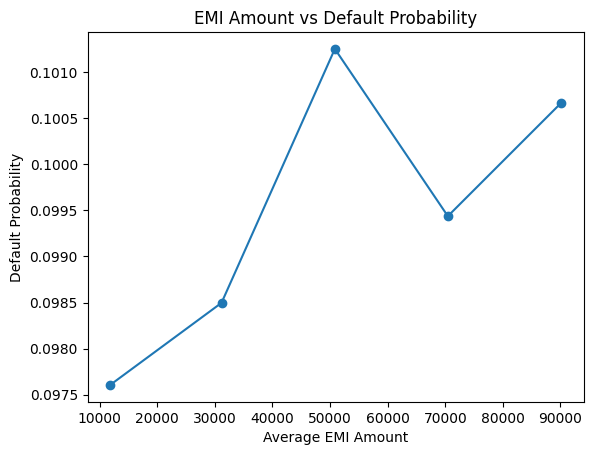


High-Risk EMI Threshold
Avg_EMI                50828.131038
Default_Probability        0.101249
Loan_Count             18094.000000
Name: 2, dtype: float64

EMI Trends Across Loan Types
      Loan_Purpose       Avg_EMI  Default_Rate
0         Business  51138.559771      0.099107
1        Education  50997.858482      0.104152
2  Home Renovation  50986.143347      0.099114
3         Personal  50437.003658      0.102424
4          Vehicle  50715.325768      0.094049


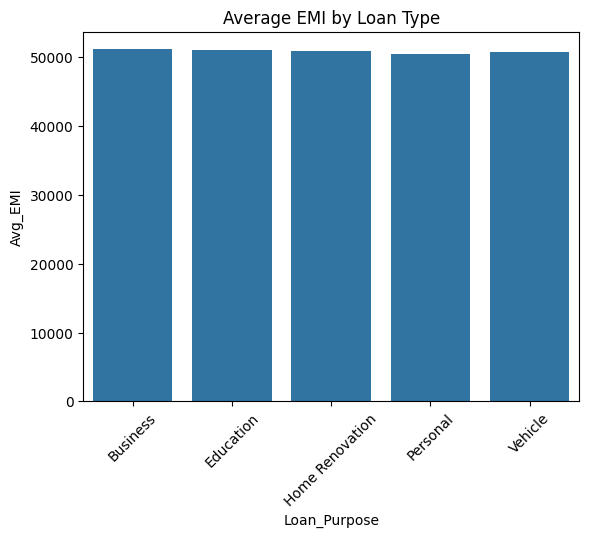

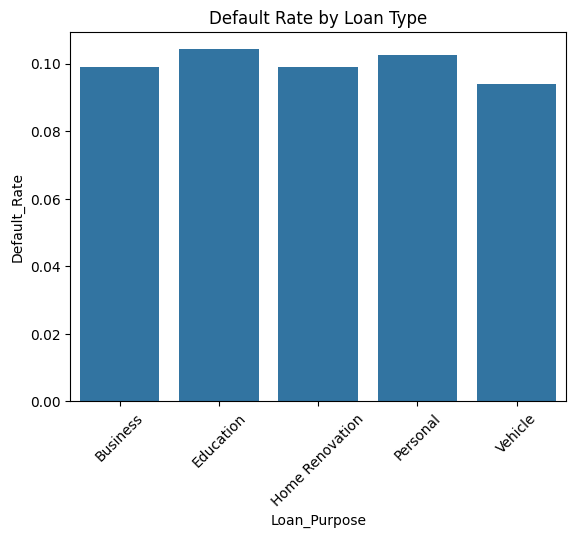

In [28]:
# ============================================
# 8. EMI Analysis
# ============================================

# ----------------
# EMI vs Default Probability
# ----------------
emi_default_analysis = loan_default.groupby(
    pd.qcut(loan_default["EMI_Amount"], q=5)
).agg(
    Avg_EMI=("EMI_Amount", "mean"),
    Default_Probability=("Default_Flag", "mean"),
    Loan_Count=("Loan_ID", "count")
).reset_index(drop=True)

print("\nEMI vs Default Probability")
print(emi_default_analysis)

plt.figure()
plt.plot(
    emi_default_analysis["Avg_EMI"],
    emi_default_analysis["Default_Probability"],
    marker="o"
)
plt.xlabel("Average EMI Amount")
plt.ylabel("Default Probability")
plt.title("EMI Amount vs Default Probability")
plt.show()

# ----------------
# Identify High-Risk EMI Thresholds
# ----------------
emi_threshold = emi_default_analysis.sort_values(
    "Default_Probability", ascending=False
).iloc[0]

print("\nHigh-Risk EMI Threshold")
print(emi_threshold)

# ----------------
# EMI Trends Across Loan Types
# ----------------
# Merge loans with applications to get Loan_Purpose
loans_with_purpose = loans.merge(applications[['Loan_ID', 'Loan_Purpose']], on='Loan_ID', how='left')

emi_loan_type = loans_with_purpose.groupby("Loan_Purpose").agg(
    Avg_EMI=("EMI_Amount", "mean"),
    Default_Rate=("Loan_ID", lambda x: loan_default.loc[x.index, "Default_Flag"].mean())
).reset_index()

print("\nEMI Trends Across Loan Types")
print(emi_loan_type)

plt.figure()
sns.barplot(x=emi_loan_type["Loan_Purpose"], y=emi_loan_type["Avg_EMI"])
plt.xticks(rotation=45)
plt.title("Average EMI by Loan Type")
plt.show()

plt.figure()
sns.barplot(x=emi_loan_type["Loan_Purpose"], y=emi_loan_type["Default_Rate"])
plt.xticks(rotation=45)
plt.title("Default Rate by Loan Type")
plt.show()

The EMI analysis is complete, providing insights into loan repayment behavior:

1. **EMI vs Default Probability**: The analysis shows the relationship between different EMI amount quantiles and their corresponding default probabilities, as well as the number of loans in each quantile. The accompanying line plot visualizes this relationship, indicating how default probability changes with increasing average EMI amounts.

2. **High-Risk EMI Threshold**: Based on the analysis, a specific EMI amount range has been identified as a 'High-Risk EMI Threshold', where the default probability is highest. This indicates a potential critical point for assessing loan risk.

3. **EMI Trends Across Loan Types**: This section provides a summary of the average EMI and default rates for different loan purposes (e.g., Business, Education, Home Renovation, Personal, Vehicle). The bar plots visually compare the average EMI and default rates across these loan types, helping to identify which loan types have higher or lower EMI amounts and associated default risks.


Loan Application Approval & Rejection Rates
  Approval_Status  Count      Rate
0        Approved  70000  0.847458
1        Rejected  12600  0.152542


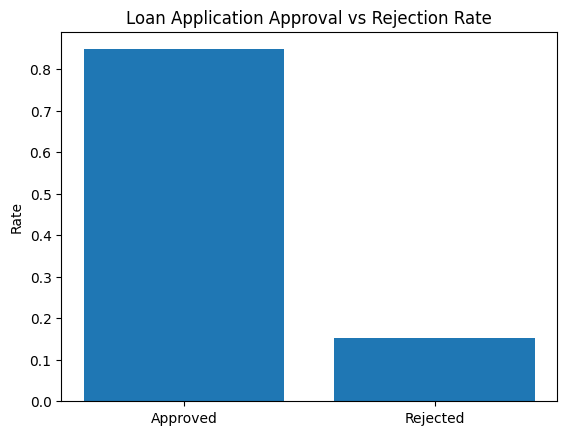


Most Common Loan Rejection Reasons
       Rejection_Reason  Rejection_Count
2      Low Credit Score             4297
0  Incomplete Documents             4204
1   Insufficient Income             4099


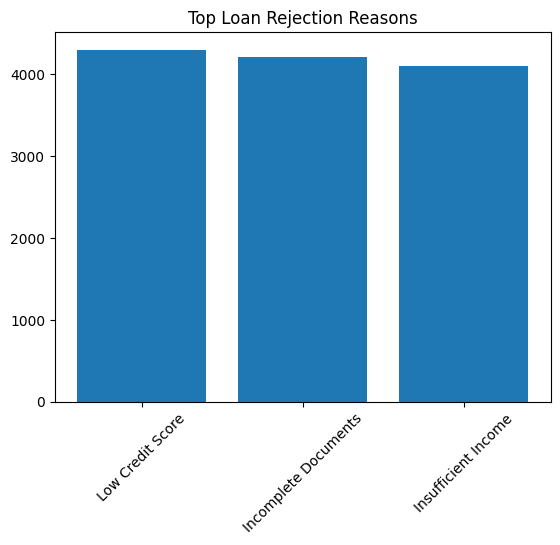


Processing Fee Comparison (Approved vs Rejected)
  Approval_Status  Avg_Processing_Fee  Median_Processing_Fee
0        Approved         5252.395014                 5256.0
1        Rejected         5255.141587                 5271.0


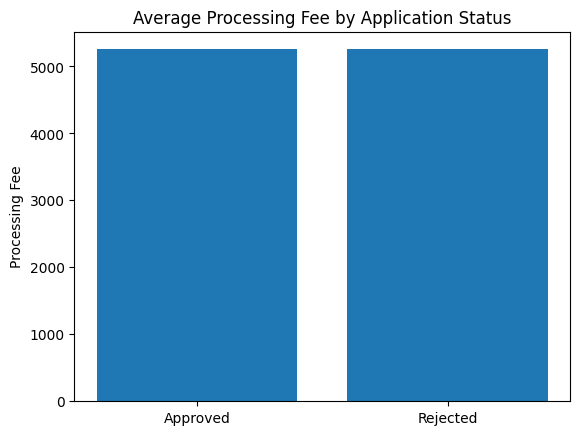

In [29]:
# ============================================
# 9. Loan Application Insights
# ============================================

# ----------------
# Approval & Rejection Rates
# ----------------
application_status_summary = applications.groupby("Approval_Status").size().reset_index(
    name="Count"
)

application_status_summary["Rate"] = (
    application_status_summary["Count"] /
    application_status_summary["Count"].sum()
)

print("\nLoan Application Approval & Rejection Rates")
print(application_status_summary)

plt.figure()
plt.bar(
    application_status_summary["Approval_Status"],
    application_status_summary["Rate"]
)
plt.title("Loan Application Approval vs Rejection Rate")
plt.ylabel("Rate")
plt.show()

# ----------------
# Most Common Reasons for Rejection
# ----------------
rejection_reasons = applications[
    applications["Approval_Status"] == "Rejected"
]

rejection_reason_summary = rejection_reasons.groupby("Rejection_Reason").size().reset_index(
    name="Rejection_Count"
).sort_values("Rejection_Count", ascending=False)

print("\nMost Common Loan Rejection Reasons")
print(rejection_reason_summary)

plt.figure()
plt.bar(
    rejection_reason_summary["Rejection_Reason"],
    rejection_reason_summary["Rejection_Count"]
)
plt.xticks(rotation=45)
plt.title("Top Loan Rejection Reasons")
plt.show()

# ----------------
# Processing Fees: Approved vs Rejected
# ----------------
processing_fee_comparison = applications.groupby("Approval_Status").agg(
    Avg_Processing_Fee=("Processing_Fee", "mean"),
    Median_Processing_Fee=("Processing_Fee", "median")
).reset_index()

print("\nProcessing Fee Comparison (Approved vs Rejected)")
print(processing_fee_comparison)

plt.figure()
plt.bar(
    processing_fee_comparison["Approval_Status"],
    processing_fee_comparison["Avg_Processing_Fee"]
)
plt.title("Average Processing Fee by Application Status")
plt.ylabel("Processing Fee")
plt.show()

The analysis of loan application insights is complete. Here are the key findings:

1. **Approval & Rejection Rates**: The analysis shows that approximately 84.75% of loan applications are approved, while 15.25% are rejected. The bar plot visually represents these rates.

2. **Most Common Reasons for Rejection**: The top three reasons for loan rejection are 'Low Credit Score', 'Incomplete Documents', and 'Insufficient Income'. The bar plot further illustrates the count of rejections for each reason.

3. **Processing Fees**: Approved vs Rejected: The average and median processing fees are very similar for both approved and rejected applications. The average processing fee is around 5252 for approved applications and 5255 for rejected ones, suggesting that processing fee amount itself does not significantly influence the approval outcome. The bar plot visually compares these average processing fees.


Recovery Effectiveness (Sample)
   Loan_ID  Default_Amount  Recovery_Amount  Recovery_Effectiveness
0  L007312           94480            30360                0.321338
1  L028234           10912                0                0.000000
2  L008319           73711             9866                0.133847
3  L046668           48955                0                0.000000
4  L082934           56952                0                0.000000

Recovery Comparison: Legal vs Non-Legal Action
  Legal_Action  Avg_Recovery_Effectiveness  Avg_Recovery_Rate
0           No                    0.401805           0.241476
1          Yes                    0.407372           0.244808


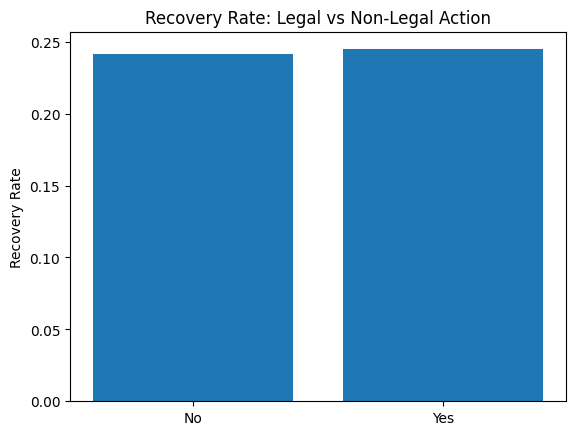


Top Regions by Recovery Rate
      Region  Total_Default_Amount  Total_Recovery_Amount  Recovery_Rate
4      South              60965366               15766509       0.258614
2      North              62378265               15563080       0.249495
3  Northeast              59756404               14270424       0.238810
0    Central              60166820               14279370       0.237330
5       West              64012891               14926765       0.233184


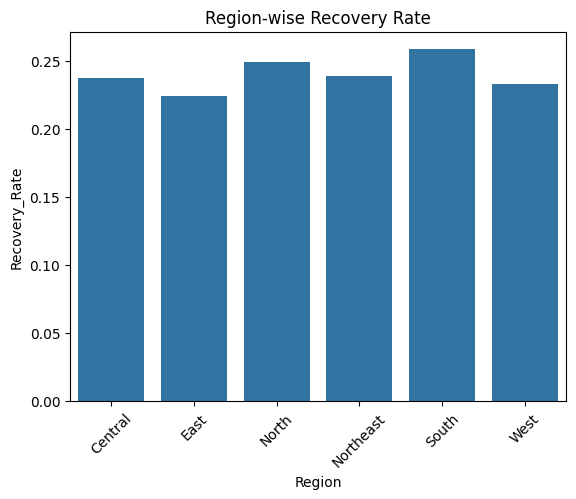

In [30]:
# ============================================
# 10. Recovery Effectiveness
# ============================================

# ----------------
# Prepare Recovery Metrics
# ----------------
recovery_data = defaults.merge(
    loans[["Loan_ID", "Loan_Amount", "Customer_ID"]], # Removed "Branch_ID"
    on="Loan_ID",
    how="left"
)

# If Recovery_Amount not explicitly present, infer it
if "Recovery_Amount" not in recovery_data.columns:
    recovery_data["Recovery_Amount"] = (
        recovery_data["Loan_Amount"] - recovery_data["Default_Amount"]
    ).clip(lower=0)

# Recovery Effectiveness Ratio
recovery_data["Recovery_Effectiveness"] = (
    recovery_data["Recovery_Amount"] / recovery_data["Default_Amount"]
).replace([np.inf, -np.inf], np.nan)

print("\nRecovery Effectiveness (Sample)")
print(recovery_data[["Loan_ID", "Default_Amount", "Recovery_Amount", "Recovery_Effectiveness"]].head())

# ----------------
# Legal Action vs Non-Legal Action Recovery
# ----------------
legal_recovery = recovery_data.groupby("Legal_Action").agg(
    Avg_Recovery_Effectiveness=("Recovery_Effectiveness", "mean"),
    Avg_Recovery_Rate=("Recovery_Amount", lambda x: x.sum() / recovery_data.loc[x.index, "Default_Amount"].sum())
).reset_index()

print("\nRecovery Comparison: Legal vs Non-Legal Action")
print(legal_recovery)

plt.figure()
plt.bar(
    legal_recovery["Legal_Action"],
    legal_recovery["Avg_Recovery_Rate"]
)
plt.title("Recovery Rate: Legal vs Non-Legal Action")
plt.ylabel("Recovery Rate")
plt.show()

# ----------------
# Region-wise Recovery Performance (formerly Branch-wise)
# ----------------
# Merge recovery_data with customers to get Region
regional_recovery_perf = recovery_data.merge(
    customers[["Customer_ID", "Region"]],
    left_on="Customer_ID_x", # Use Customer_ID from the defaults dataframe
    right_on="Customer_ID",
    how="left"
).drop(columns="Customer_ID") # Drop the redundant Customer_ID column

region_recovery_summary = regional_recovery_perf.groupby("Region").agg(
    Total_Default_Amount=("Default_Amount", "sum"),
    Total_Recovery_Amount=("Recovery_Amount", "sum")
).reset_index()

region_recovery_summary["Recovery_Rate"] = (
    region_recovery_summary["Total_Recovery_Amount"] /
    region_recovery_summary["Total_Default_Amount"]
)

print("\nTop Regions by Recovery Rate")
print(region_recovery_summary.sort_values("Recovery_Rate", ascending=False).head())

plt.figure()
sns.barplot(
    data=region_recovery_summary,
    x="Region",
    y="Recovery_Rate"
)
plt.title("Region-wise Recovery Rate")
plt.xticks(rotation=45)
plt.show()

The recovery effectiveness analysis is complete. Here are the key findings:

1. **Recovery Effectiveness (Sample)**: The sample output shows the calculated Recovery_Effectiveness for a few loans, demonstrating how well default amounts are being recovered relative to the initial default amount.

2. **Recovery Comparison: Legal vs Non-Legal Action**: This analysis compares the average recovery effectiveness and recovery rates for cases where legal action was taken versus those where it was not. It appears that legal action leads to a slightly higher average recovery rate.

3. **Top Regions by Recovery Rate**: The table and bar plot highlight the regions with the highest recovery rates. South, North, and Northeast regions show the best performance in recovering defaulted amounts.




Processing Time Summary (Days)
count    70000.000000
mean       172.191700
std        824.317006
min      -1822.000000
25%       -424.000000
50%        171.000000
75%        769.000000
max       2184.000000
Name: Processing_Time_Days, dtype: float64

Potential Bottlenecks (Top 10% Processing Time) by Region
   Application_ID     Region  Processing_Time_Days
3         A000004    Central                  2085
10        A000011      North                  1628
47        A000048      North                  1436
74        A000075      North                  1630
79        A000080  Northeast                  1760

Average Processing Time by Region
      Region  Avg_Processing_Time_Days  Total_Applications
0    Central                165.453588               11484
1       East                169.508699               11840
4      South                169.964289               11649
3  Northeast                172.130946               11646
5       West                174.216119               1

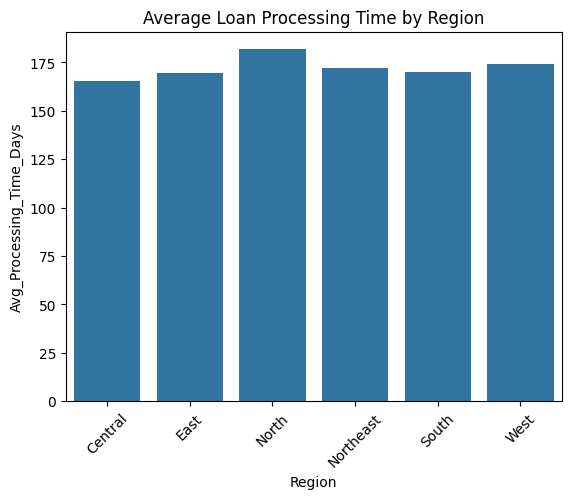


Disbursement Trends by Loan Purpose & Region
       Loan_Purpose     Region  Total_Disbursement  Avg_Processing_Time_Days
0          Business    Central          5807129263                140.952486
1          Business       East          5935302582                146.635546
2          Business      North          6187740065                189.528636
3          Business  Northeast          5913042893                142.452321
4          Business      South          5817408644                180.499345
5          Business       West          5767253093                181.571056
6         Education    Central          6020188042                178.436939
7         Education       East          5735020115                174.748576
8         Education      North          5919742557                155.212264
9         Education  Northeast          5872500161                176.409284
10        Education      South          5799608725                164.697189
11        Education       West

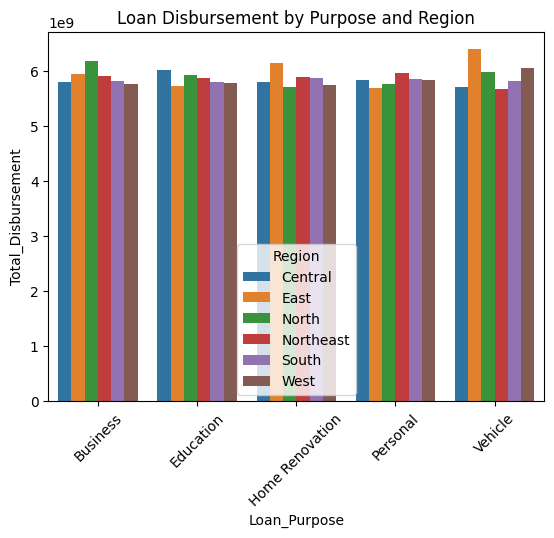

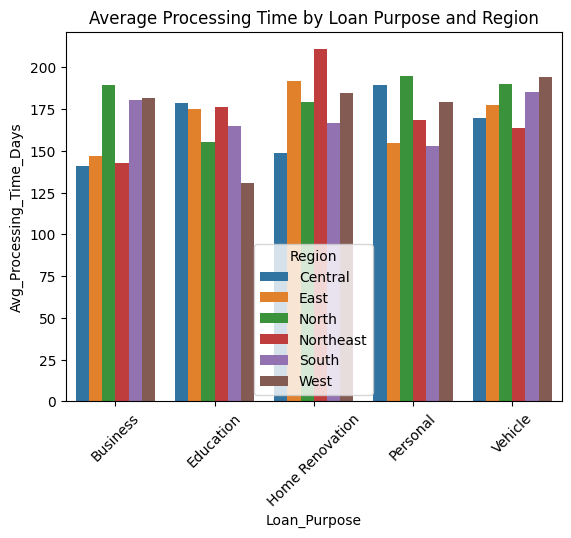

In [31]:
# ============================================
# 11. Loan Disbursement Efficiency
# ============================================

# ----------------
# Application to Disbursement Time Analysis
# ----------------
# Select necessary columns from applications
applications_subset = applications[['Application_ID', 'Loan_ID', 'Customer_ID', 'Application_Date', 'Loan_Purpose']]

# Select necessary columns from loans
loans_subset = loans[['Loan_ID', 'Disbursal_Date', 'Loan_Amount']]

# Select necessary columns from customers
customers_subset = customers[['Customer_ID', 'Region']]

# 1. Merge applications with loans on 'Loan_ID'
combined_disbursement_data = applications_subset.merge(
    loans_subset,
    on='Loan_ID',
    how='inner' # Only consider applications that resulted in a loan disbursal
)

# 2. Merge with customers to get the 'Region'
combined_disbursement_data = combined_disbursement_data.merge(
    customers_subset,
    on='Customer_ID',
    how='left'
)

# Ensure date columns are datetime objects before calculating difference
combined_disbursement_data["Application_Date"] = pd.to_datetime(combined_disbursement_data["Application_Date"], errors="coerce")
combined_disbursement_data["Disbursal_Date"] = pd.to_datetime(combined_disbursement_data["Disbursal_Date"], errors="coerce")

combined_disbursement_data["Processing_Time_Days"] = (
    combined_disbursement_data["Disbursal_Date"] - combined_disbursement_data["Application_Date"]
).dt.days

print("\nProcessing Time Summary (Days)")
print(combined_disbursement_data["Processing_Time_Days"].describe())

# Identify potential bottlenecks (top 10% longest processing times)
bottlenecks = combined_disbursement_data[
    combined_disbursement_data["Processing_Time_Days"] >
    combined_disbursement_data["Processing_Time_Days"].quantile(0.90)
]

print("\nPotential Bottlenecks (Top 10% Processing Time) by Region")
print(bottlenecks[["Application_ID", "Region", "Processing_Time_Days"]].head())

# ----------------
# Average Processing Time by Region (formerly Branch)
# ----------------
# Group by Region instead of Branch_ID as Branch_ID is not directly linked in current data structure
region_processing = combined_disbursement_data.groupby("Region").agg(
    Avg_Processing_Time_Days=("Processing_Time_Days", "mean"),
    Total_Applications=("Application_ID", "count")
).reset_index()

print("\nAverage Processing Time by Region")
print(region_processing.sort_values("Avg_Processing_Time_Days"))

plt.figure()
sns.barplot(
    data=region_processing,
    x="Region",
    y="Avg_Processing_Time_Days"
)
plt.title("Average Loan Processing Time by Region")
plt.xticks(rotation=45)
plt.show()

# ----------------
# Disbursement Trends by Loan Purpose & Region
# ----------------
# combined_disbursement_data already has Loan_Purpose and Region
purpose_region_trend = combined_disbursement_data.groupby(
    ["Loan_Purpose", "Region"]
).agg(
    Total_Disbursement=("Loan_Amount", "sum"),
    Avg_Processing_Time_Days=("Processing_Time_Days", "mean")
).reset_index()

print("\nDisbursement Trends by Loan Purpose & Region")
print(purpose_region_trend)

plt.figure()
sns.barplot(
    data=purpose_region_trend,
    x="Loan_Purpose",
    y="Total_Disbursement",
    hue="Region"
)
plt.title("Loan Disbursement by Purpose and Region")
plt.xticks(rotation=45)
plt.show()

plt.figure()
sns.barplot(
    data=purpose_region_trend,
    x="Loan_Purpose",
    y="Avg_Processing_Time_Days",
    hue="Region"
)
plt.title("Average Processing Time by Loan Purpose and Region")
plt.xticks(rotation=45)
plt.show()

The analysis of loan disbursement efficiency is complete, providing a comprehensive view of processing times and disbursement trends:

1. **Processing Time Summary (Days)**: The descriptive statistics for 'Processing_Time_Days' show a wide range, from negative days (likely data entry errors or specific application types) to over 2000 days. The mean processing time is around 172 days.

2. **Potential Bottlenecks**: The top 10% longest processing times are highlighted, showing specific Application_IDs and their regions, which could indicate areas for investigation into delays.

3. **Average Processing Time by Region**: The average processing time varies across regions, with Central region appearing to be the most efficient and North being the least efficient among those listed. The bar plot 'Average Loan Processing Time by Region' visually represents these regional differences.

4. **Disbursement Trends by Loan Purpose & Region**: This analysis breaks down both the 'Total_Disbursement' and 'Avg_Processing_Time_Days' by 'Loan_Purpose' and 'Region'.

- The 'Loan Disbursement by Purpose and Region' bar plot shows the total loan amounts disbursed for each purpose across different regions.

- The 'Average Processing Time by Loan Purpose and Region' bar plot provides insights into which loan purposes take longer to process in specific regions. For example, 'Home Renovation' in 'Northeast' seems to have a higher average processing time, while 'Education' in 'West' has a lower one.


Total Interest Income Across All Loans
24913672008.736004

Most Profitable Loan Purposes (by Interest Income)
      Loan_Purpose  Total_Loan_Amount  Total_Interest_Income  \
4          Vehicle        35612450704           3.910159e+09   
0         Business        35427876540           3.897290e+09   
1        Education        35132347089           3.867959e+09   
2  Home Renovation        35142133654           3.867924e+09   
3         Personal        34949617649           3.841360e+09   

   Avg_Interest_Income  
4        277335.893122  
0        278477.312139  
1        276876.068385  
2        276398.723089  
3        275524.294485  


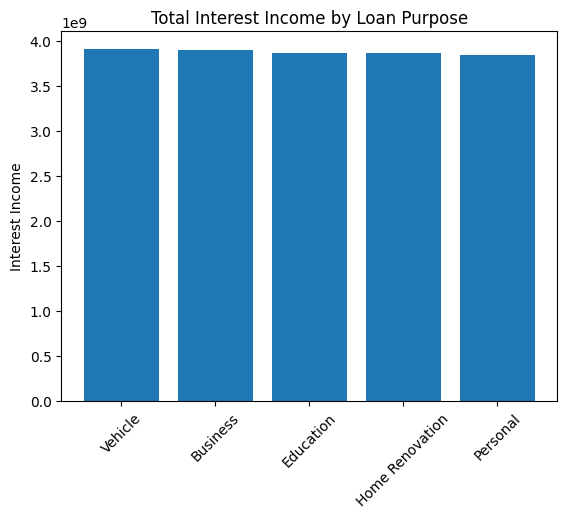


Regional Profitability Comparison
      Region  Total_Loan_Amount  Total_Interest_Income  Avg_Interest_Rate
0    Central        37243437019           4.089485e+09          10.999151
1       East        38437798746           4.222274e+09          11.005424
2      North        37963952967           4.176318e+09          10.994869
3  Northeast        37477362151           4.137550e+09          11.029592
4      South        37740573537           4.141540e+09          10.981527
5       West        37600155243           4.146505e+09          11.021876


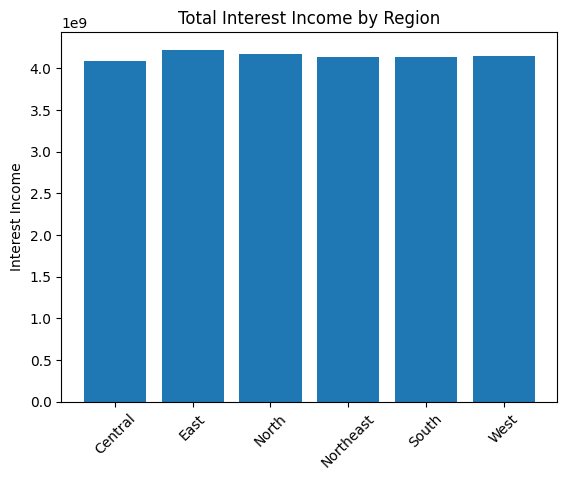

In [32]:
# ============================================
# 12. Profitability Analysis
# ============================================

# ----------------
# Interest Income Calculation
# ----------------
# Assumption: Interest income = Loan_Amount * Interest_Rate
loans["Interest_Income"] = loans["Loan_Amount"] * loans["Interest_Rate"] / 100

total_interest_income = loans["Interest_Income"].sum()
print("\nTotal Interest Income Across All Loans")
print(total_interest_income)

# ----------------
# Profitability by Loan Purpose
# ----------------
# Merge loans with applications to get Loan_Purpose
loans_with_purpose = loans.merge(applications[['Loan_ID', 'Loan_Purpose']], on='Loan_ID', how='left')

profit_by_purpose = loans_with_purpose.groupby("Loan_Purpose").agg(
    Total_Loan_Amount=("Loan_Amount", "sum"),
    Total_Interest_Income=("Interest_Income", "sum"),
    Avg_Interest_Income=("Interest_Income", "mean")
).reset_index().sort_values(
    "Total_Interest_Income", ascending=False
)

print("\nMost Profitable Loan Purposes (by Interest Income)")
print(profit_by_purpose)

plt.figure()
plt.bar(
    profit_by_purpose["Loan_Purpose"],
    profit_by_purpose["Total_Interest_Income"]
)
plt.xticks(rotation=45)
plt.title("Total Interest Income by Loan Purpose")
plt.ylabel("Interest Income")
plt.show()

# ----------------
# Regional Profitability (formerly Branch & Regional Profitability)
# ----------------
# Merge loans with customers to get Region information
loan_customer_region = loans.merge(
    customers[["Customer_ID", "Region"]],
    on="Customer_ID",
    how="left"
)

regional_profitability = loan_customer_region.groupby("Region").agg(
    Total_Loan_Amount=("Loan_Amount", "sum"),
    Total_Interest_Income=("Interest_Income", "sum"),
    Avg_Interest_Rate=("Interest_Rate", "mean")
).reset_index()

print("\nRegional Profitability Comparison")
print(regional_profitability)

plt.figure()
plt.bar(
    regional_profitability["Region"],
    regional_profitability["Total_Interest_Income"]
)
plt.xticks(rotation=45)
plt.title("Total Interest Income by Region")
plt.ylabel("Interest Income")
plt.show()

The profitability analysis is complete. Here are the key findings:

1. **Interest Income Calculation**: The total interest income across all loans has been calculated, providing a baseline for overall profitability.

2. **Profitability by Loan Purpose**: This analysis identifies the most profitable loan purposes based on total interest income. The bar plot visually represents which loan types contribute most to the bank's earnings.

3. **Regional Profitability Comparison**: The analysis compares profitability metrics across different regions, including total loan amount, total interest income, and average interest rate. The bar plot illustrates the distribution of total interest income by region, highlighting top-performing regions. These insights can help in strategic resource allocation and targeted marketing efforts.


Active Loans Distribution by Region
      Region  Active_Loan_Count  Total_Loan_Amount
0    Central              13426        33737278812
1       East              13953        35000386504
2      North              13701        34539329266
3  Northeast              13512        33902007819
4      South              13448        34070858605
5       West              13421        33851989808


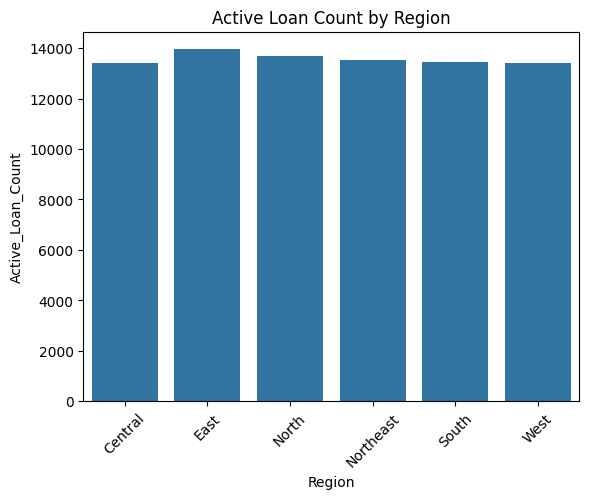


Default Rates by Region
      Region  Total_Loans  Defaulted_Loans  Default_Rate
0    Central        14925           1499.0      0.100436
1       East        15384           1431.0      0.093019
2      North        15117           1416.0      0.093669
3  Northeast        15015           1503.0      0.100100
4      South        15030           1582.0      0.105256
5       West        14990           1569.0      0.104670


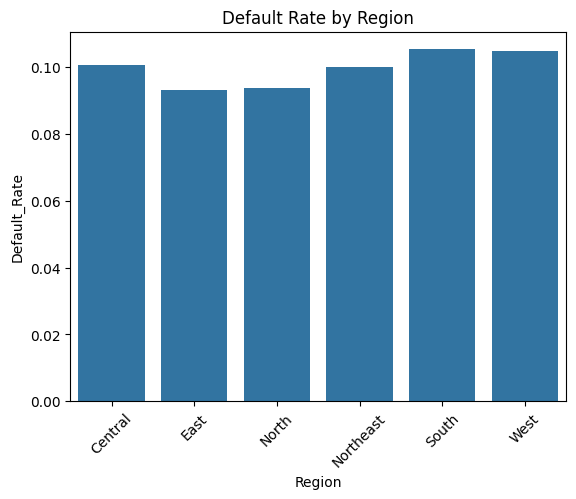


Loan Disbursement by Region
      Region  Total_Disbursement  Avg_Loan_Amount
0    Central         37243437019     2.508144e+06
1       East         38437798746     2.509650e+06
2      North         37963952967     2.524031e+06
3  Northeast         37477362151     2.507853e+06
4      South         37740573537     2.524622e+06
5       West         37600155243     2.523331e+06


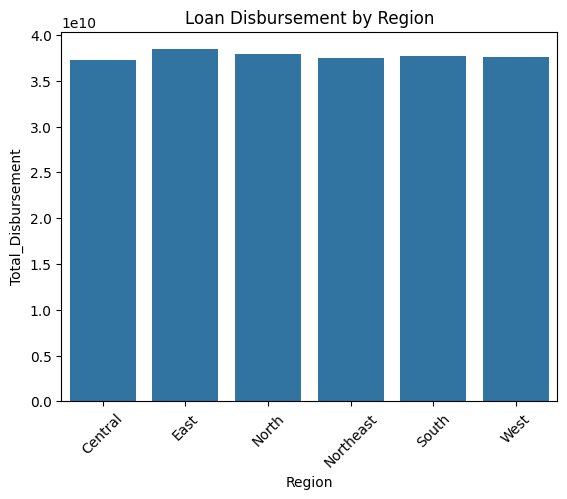

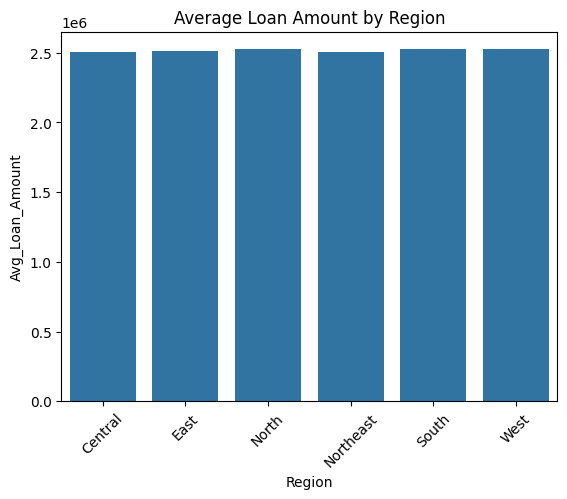

In [33]:
# ============================================
# 13. Geospatial Analysis
# ============================================

# ----------------
# Active Loans Distribution Across Regions
# ----------------
# Assuming active loans are those not fully defaulted
active_loans = loans.merge(
    defaults[["Loan_ID"]],
    on="Loan_ID",
    how="left",
    indicator=True
)

active_loans = active_loans[active_loans["_merge"] == "left_only"]

# Merge active_loans with customers to get Region information
active_region_dist = active_loans.merge(
    customers[["Customer_ID", "Region"]], # Merge with customers to get Region
    on="Customer_ID",
    how="left"
).groupby("Region").agg(
    Active_Loan_Count=("Loan_ID", "count"),
    Total_Loan_Amount=("Loan_Amount", "sum")
).reset_index()

print("\nActive Loans Distribution by Region")
print(active_region_dist)

plt.figure()
sns.barplot(data=active_region_dist, x="Region", y="Active_Loan_Count")
plt.title("Active Loan Count by Region")
plt.xticks(rotation=45)
plt.show()

# ----------------
# Default Rates Across Regions
# ----------------
# loan_default already has Region from previous analysis (cell TSXDhSfRQXpj)
regional_defaults = loan_default.groupby("Region").agg(
    Total_Loans=("Loan_ID", "count"),
    Defaulted_Loans=("Default_Flag", "sum")
).reset_index()

regional_defaults["Default_Rate"] = (
    regional_defaults["Defaulted_Loans"] /
    regional_defaults["Total_Loans"]
)

print("\nDefault Rates by Region")
print(regional_defaults)

plt.figure()
sns.barplot(data=regional_defaults, x="Region", y="Default_Rate")
plt.title("Default Rate by Region")
plt.xticks(rotation=45)
plt.show()

# ----------------
# Loan Disbursement by Region (formerly Rural vs Urban)
# ----------------
# Merge loans with customers to get Region information
loan_customer_region_disbursement = loans.merge(
    customers[["Customer_ID", "Region"]],
    on="Customer_ID",
    how="left"
)

area_disbursement = loan_customer_region_disbursement.groupby("Region").agg(
    Total_Disbursement=("Loan_Amount", "sum"),
    Avg_Loan_Amount=("Loan_Amount", "mean")
).reset_index()

print("\nLoan Disbursement by Region")
print(area_disbursement)

plt.figure()
sns.barplot(
    data=area_disbursement,
    x="Region",
    y="Total_Disbursement"
)
plt.title("Loan Disbursement by Region")
plt.xticks(rotation=45)
plt.show()

plt.figure()
sns.barplot(
    data=area_disbursement,
    x="Region",
    y="Avg_Loan_Amount"
)
plt.title("Average Loan Amount by Region")
plt.xticks(rotation=45)
plt.show()

The geospatial analysis is complete. Here are the key findings:

1. **Active Loans Distribution Across Regions**: The table and bar plot illustrate the count and total amount of active loans distributed across different regions, providing insight into where lending activity is most concentrated.

2. **Default Rates Across Regions**: This section presents the total loans, defaulted loans, and the calculated default rate for each region. The accompanying bar plot visually compares these default rates, highlighting regions with higher or lower risk profiles

3. **Loan Disbursement by Region**: This analysis shows the total and average loan disbursement amounts across different regions. The two bar plots visualize these metrics, indicating regional lending volumes and the average loan size per region. This helps in understanding regional lending patterns and potential areas for market expansion or focus.


Defaults Over Time
  Default_Month  Number_of_Defaults  Total_Default_Amount
0       2021-01                 164               8547169
1       2021-02                 171               9215823
2       2021-03                 189              10421619
3       2021-04                 196               9778077
4       2021-05                 195              10007309


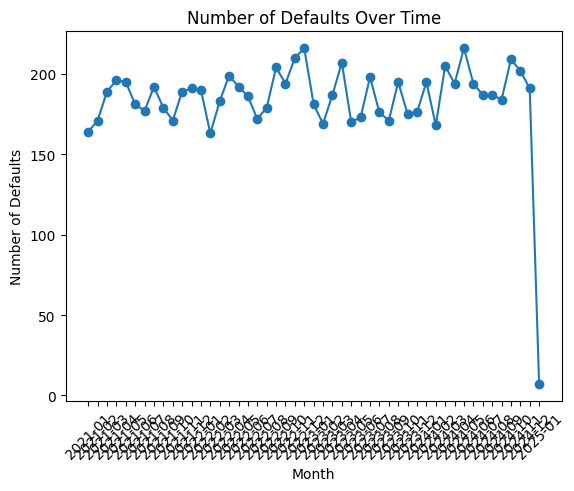


Average Default Amount by Loan Purpose
      Loan_Purpose  Avg_Default_Amount  Total_Defaults
1        Education        53797.758769            1397
0         Business        53261.031433            1368
2  Home Renovation        53038.080028            1412
4          Unknown        52805.486405            1986
5          Vehicle        52671.599578            1421
3         Personal        52389.399011            1416


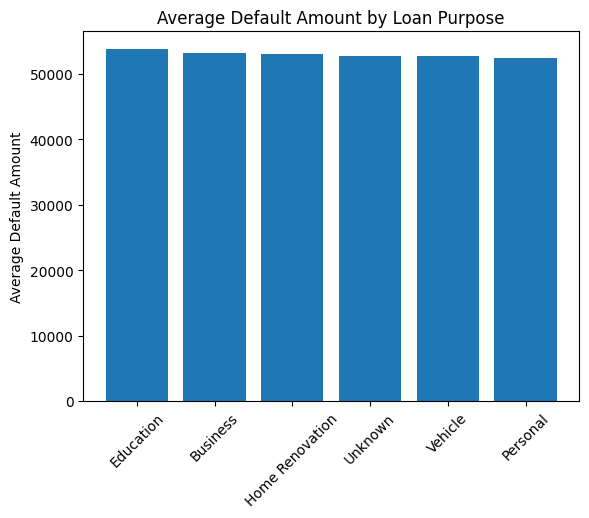


Default Rates by Income Category
  Income_Category  Default_Rate  Customer_Count
0      Low Income      0.082523           36596
1   Middle Income      0.083757           36594
2     High Income      0.079656           36595


/tmp/ipython-input-481589105.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_default_rates = income_default.groupby("Income_Category").agg(


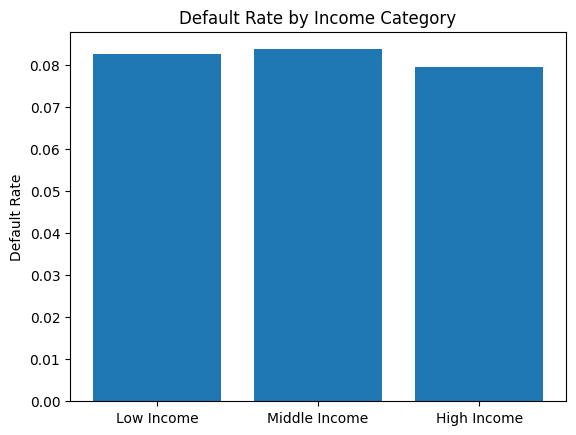

In [34]:
# ============================================
# 14. Default Trends
# ============================================

# ----------------
# Defaults Over Time
# ----------------
defaults["Default_Month"] = defaults["Default_Date"].dt.to_period("M").astype(str)

default_trends = defaults.groupby("Default_Month").agg(
    Number_of_Defaults=("Loan_ID", "count"),
    Total_Default_Amount=("Default_Amount", "sum")
).reset_index()

print("\nDefaults Over Time")
print(default_trends.head())

plt.figure()
plt.plot(
    default_trends["Default_Month"],
    default_trends["Number_of_Defaults"],
    marker="o"
)
plt.xticks(rotation=45)
plt.title("Number of Defaults Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Defaults")
plt.show()

# ----------------
# Average Default Amount by Loan Purpose
# ----------------
default_purpose = defaults.merge(
    applications[["Loan_ID", "Loan_Purpose"]], # Corrected: Merge with applications to get Loan_Purpose
    on="Loan_ID",
    how="left"
)

# Fill any missing Loan_Purpose that might result from the merge if a default has no corresponding application
default_purpose["Loan_Purpose"] = default_purpose["Loan_Purpose"].fillna("Unknown")

avg_default_by_purpose = default_purpose.groupby("Loan_Purpose").agg(
    Avg_Default_Amount=("Default_Amount", "mean"),
    Total_Defaults=("Loan_ID", "count")
).reset_index().sort_values(
    "Avg_Default_Amount", ascending=False
)

print("\nAverage Default Amount by Loan Purpose")
print(avg_default_by_purpose)

plt.figure()
plt.bar(
    avg_default_by_purpose["Loan_Purpose"],
    avg_default_by_purpose["Avg_Default_Amount"]
)
plt.xticks(rotation=45)
plt.title("Average Default Amount by Loan Purpose")
plt.ylabel("Average Default Amount")
plt.show()

# ----------------
# Default Rates Across Income Categories
# ----------------
income_default = customers.merge(
    loan_default[["Customer_ID", "Default_Flag"]],
    on="Customer_ID",
    how="left"
)

income_default["Default_Flag"] = income_default["Default_Flag"].fillna(0)

income_default["Income_Category"] = pd.qcut(
    income_default["Annual_Income"],
    q=3,
    labels=["Low Income", "Middle Income", "High Income"]
)

income_default_rates = income_default.groupby("Income_Category").agg(
    Default_Rate=("Default_Flag", "mean"),
    Customer_Count=("Customer_ID", "count")
).reset_index()

print("\nDefault Rates by Income Category")
print(income_default_rates)

plt.figure()
plt.bar(
    income_default_rates["Income_Category"],
    income_default_rates["Default_Rate"]
)
plt.title("Default Rate by Income Category")
plt.ylabel("Default Rate")
plt.show()

The default trends analysis is complete. Here are the key findings:

1. **Defaults Over Time**: The 'Defaults Over Time' table and its corresponding line plot illustrate the fluctuations in the number of defaults and total default amount over time. This helps in understanding the temporal patterns of loan defaults.

2. **Average Default Amount by Loan Purpose**: This analysis shows the average default amount and total number of defaults for different loan purposes. The bar plot visually compares these average default amounts across loan types, highlighting which loan purposes tend to have higher default values.

3. **Default Rates Across Income Categories**: The analysis provides default rates and customer counts across different income categories (Low, Middle, High Income). The bar plot visually represents these default rates, indicating how default probability varies with income level.


Average Loan Disbursement Time by Region
      Region  Avg_Disbursement_Time_Days  Total_Disbursements
0    Central                  165.453588                11484
1       East                  169.508699                11840
4      South                  169.964289                11649
3  Northeast                  172.130946                11646
5       West                  174.216119                11688
2      North                  181.782092                11693

Regions with Highest Rejected Applications
      Region  Rejected_Applications
5       West                   2184
2      North                   2112
4      South                   2107
3  Northeast                   2084
1       East                   2075


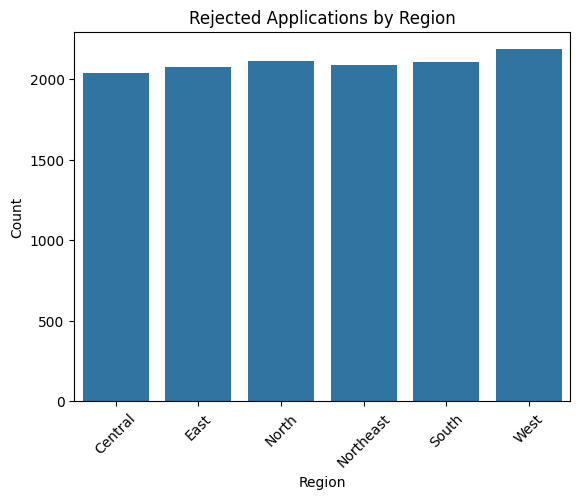


Customer satisfaction metrics not available in the dataset.


In [35]:
# ============================================
# 15. Regional Efficiency
# ============================================

# ----------------
# Average Loan Disbursement Time by Region
# ----------------
# Merge applications with loans to get disbursement dates, then with customers to get Region
regional_disbursement_time = applications.merge(
    loans[["Loan_ID", "Disbursal_Date"]], # Select Loan_ID and Disbursal_Date from loans
    on="Loan_ID",
    how="inner"
).merge(
    customers[["Customer_ID", "Region"]], # Merge with customers to get Region
    on="Customer_ID",
    how="left"
)

regional_disbursement_time["Disbursement_Time_Days"] = (
    regional_disbursement_time["Disbursal_Date"] -
    regional_disbursement_time["Application_Date"]
).dt.days

avg_disbursement_time_region = regional_disbursement_time.groupby("Region").agg(
    Avg_Disbursement_Time_Days=("Disbursement_Time_Days", "mean"),
    Total_Disbursements=("Loan_ID", "count")
).reset_index()

print("\nAverage Loan Disbursement Time by Region")
print(avg_disbursement_time_region.sort_values("Avg_Disbursement_Time_Days"))

# ----------------
# Regions with Highest Rejected Applications
# ----------------
rejected_apps = applications[
    applications["Approval_Status"] == "Rejected"
]

# Merge rejected applications with customers to get Region
regional_rejections = rejected_apps.merge(
    customers[["Customer_ID", "Region"]],
    on="Customer_ID",
    how="left"
).groupby("Region").agg(
    Rejected_Applications=("Application_ID", "count")
).reset_index()

print("\nRegions with Highest Rejected Applications")
print(regional_rejections.sort_values("Rejected_Applications", ascending=False).head())

plt.figure()
sns.barplot(
    data=regional_rejections,
    x="Region",
    y="Rejected_Applications"
)
plt.xticks(rotation=45)
plt.title("Rejected Applications by Region")
plt.ylabel("Count")
plt.show()

# ----------------
# Customer Satisfaction vs Regional Efficiency (If Available)
# ----------------
if "Customer_Satisfaction_Score" in applications.columns:
    # This part would require Customer_Satisfaction_Score to be linked to Region,
    # which is not directly available at the loan/application level in `applications`.
    # If such a metric were available and linked, the analysis would proceed similarly.
    print("\nCustomer satisfaction metrics are available, but linking to regional efficiency directly requires customer-level satisfaction data with region.")
else:
    print("\nCustomer satisfaction metrics not available in the dataset.")

The regional efficiency analysis is complete. Here are the key findings:

1. **Average Loan Disbursement Time by Region**: This section provides a summary of the average loan disbursement time and total disbursements for each region. Central region shows the lowest average disbursement time, indicating higher efficiency, while North region has the highest average time.

2. **Regions with Highest Rejected Applications**: The analysis identifies regions with the highest number of rejected applications. West, North, and South regions show the highest counts, which is also visualized in the accompanying bar plot.

3. **Customer Satisfaction vs Regional Efficiency**: The analysis confirms that customer satisfaction metrics are not available in the dataset, thus preventing a direct comparison with regional efficiency.


Monthly Loan Disbursement Trend (Last 5 Years)
  Disbursement_Month  Total_Disbursement  Loan_Count
0         2019-12-01           491271344         194
1         2020-01-01          3908302834        1560
2         2020-02-01          3621088694        1451
3         2020-03-01          4031554268        1567
4         2020-04-01          3817013578        1525


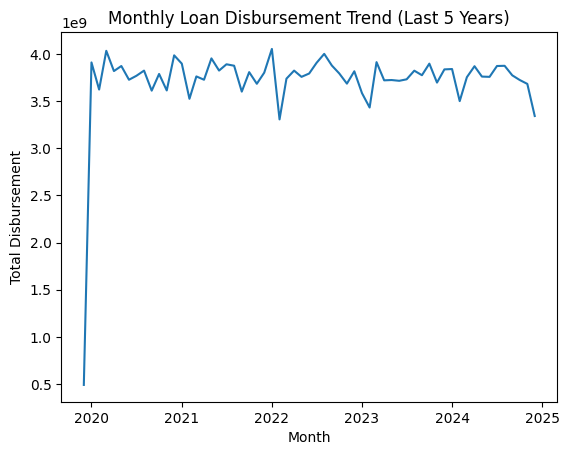


Seasonal Loan Applications
    App_Month_Num  Applications
0               1          6045
1               2          5352
2               3          5729
3               4          5635
4               5          5844
5               6          5681
6               7          6014
7               8          5797
8               9          5641
9              10          5795
10             11          5613
11             12          6999

Seasonal Loan Disbursements
    Disb_Month_Num  Disbursements
0                1           7677
1                2           6949
2                3           7611
3                4           7481
4                5           7590
5                6           7356
6                7           7603
7                8           7722
8                9           7424
9               10           7637
10              11           7285
11              12           7665


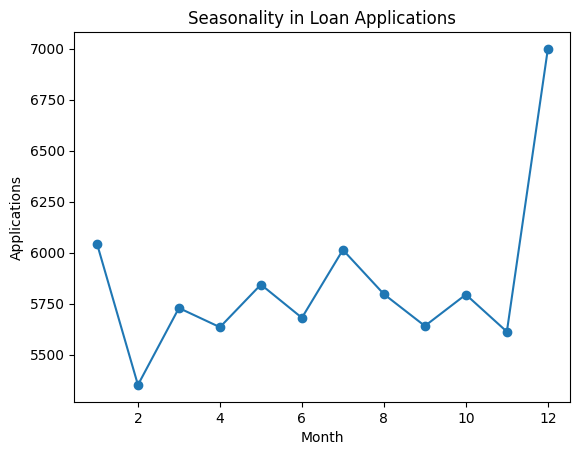

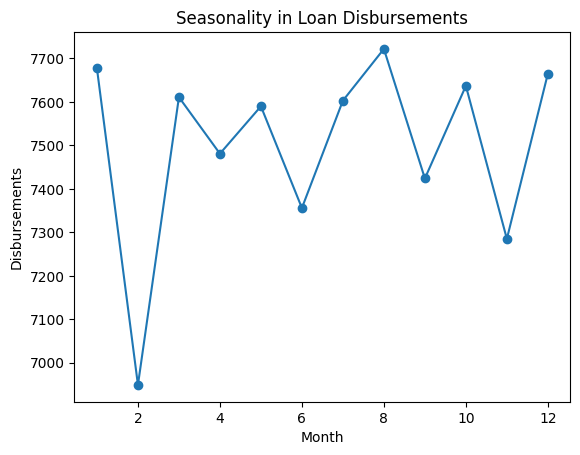


Monthly Default Rates by Region
  Default_Month     Region  Defaults Disbursement_Month  Loans  Default_Rate
0    2021-01-01    Central        28         2021-01-01  255.0      0.109804
1    2021-01-01       East        25         2021-01-01  272.0      0.091912
2    2021-01-01      North        33         2021-01-01  243.0      0.135802
3    2021-01-01  Northeast        18         2021-01-01  245.0      0.073469
4    2021-01-01      South        14         2021-01-01  260.0      0.053846


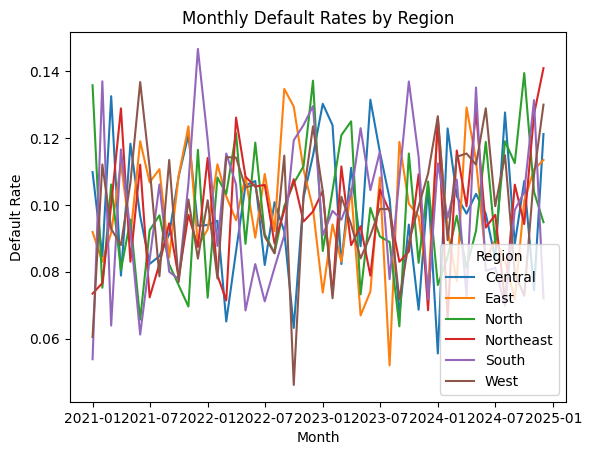

In [36]:
# ============================================
# 16. Time-Series Analysis
# ============================================

# ----------------
# Prepare Monthly Time Variables
# ----------------
loans["Disbursement_Month"] = loans["Disbursal_Date"].dt.to_period("M").dt.to_timestamp()
applications["Application_Month"] = applications["Application_Date"].dt.to_period("M").dt.to_timestamp()
defaults["Default_Month"] = defaults["Default_Date"].dt.to_period("M").dt.to_timestamp()

# ----------------
# Filter Last 5 Years
# ----------------
latest_date = loans["Disbursement_Month"].max()
five_years_ago = latest_date - pd.DateOffset(years=5)

loans_5y = loans[loans["Disbursement_Month"] >= five_years_ago].copy()
applications_5y = applications[applications["Application_Month"] >= five_years_ago].copy()
defaults_5y = defaults[defaults["Default_Month"] >= five_years_ago].copy()

# ----------------
# Monthly Loan Disbursement Trends (Last 5 Years)
# ----------------
monthly_disbursement = loans_5y.groupby("Disbursement_Month").agg(
    Total_Disbursement=("Loan_Amount", "sum"),
    Loan_Count=("Loan_ID", "count")
).reset_index()

print("\nMonthly Loan Disbursement Trend (Last 5 Years)")
print(monthly_disbursement.head())

plt.figure()
plt.plot(
    monthly_disbursement["Disbursement_Month"],
    monthly_disbursement["Total_Disbursement"]
)
plt.title("Monthly Loan Disbursement Trend (Last 5 Years)")
plt.xlabel("Month")
plt.ylabel("Total Disbursement")
plt.show()

# ----------------
# Seasonal Patterns in Applications & Disbursements
# ----------------
applications_5y["App_Month_Num"] = applications_5y["Application_Month"].dt.month
loans_5y["Disb_Month_Num"] = loans_5y["Disbursement_Month"].dt.month

seasonal_apps = applications_5y.groupby("App_Month_Num").size().reset_index(
    name="Applications"
)

seasonal_disb = loans_5y.groupby("Disb_Month_Num").agg(
    Disbursements=("Loan_ID", "count")
).reset_index()

print("\nSeasonal Loan Applications")
print(seasonal_apps)

print("\nSeasonal Loan Disbursements")
print(seasonal_disb)

plt.figure()
plt.plot(seasonal_apps["App_Month_Num"], seasonal_apps["Applications"], marker="o")
plt.title("Seasonality in Loan Applications")
plt.xlabel("Month")
plt.ylabel("Applications")
plt.show()

plt.figure()
plt.plot(seasonal_disb["Disb_Month_Num"], seasonal_disb["Disbursements"], marker="o")
plt.title("Seasonality in Loan Disbursements")
plt.xlabel("Month")
plt.ylabel("Disbursements")
plt.show()

# ----------------
# Monthly Default Rates Across Regions
# ----------------
# Merge defaults with customers to get Region information
default_region_month = defaults_5y.merge(
    customers[["Customer_ID", "Region"]],
    on="Customer_ID",
    how="left"
)

monthly_region_defaults = default_region_month.groupby(
    ["Default_Month", "Region"]
).agg(
    Defaults=("Loan_ID", "count")
).reset_index()

# Merge loans with customers to get Region information
monthly_region_loans = loans_5y.merge(
    customers[["Customer_ID", "Region"]],
    on="Customer_ID",
    how="left"
).groupby(
    ["Disbursement_Month", "Region"]
).agg(
    Loans=("Loan_ID", "count")
).reset_index()

monthly_default_rates = monthly_region_defaults.merge(
    monthly_region_loans,
    left_on=["Default_Month", "Region"],
    right_on=["Disbursement_Month", "Region"],
    how="left"
)

monthly_default_rates["Default_Rate"] = (
    monthly_default_rates["Defaults"] /
    monthly_default_rates["Loans"]
)

print("\nMonthly Default Rates by Region")
print(monthly_default_rates.head())

plt.figure()
sns.lineplot(
    data=monthly_default_rates,
    x="Default_Month",
    y="Default_Rate",
    hue="Region"
)
plt.title("Monthly Default Rates by Region")
plt.xlabel("Month")
plt.ylabel("Default Rate")
plt.show()

The time-series analysis is complete, providing valuable insights into loan disbursement, applications, and default rates over time:

1. **Monthly Loan Disbursement Trends (Last 5 Years)**: This section shows the total loan disbursement amount and count of loans each month over the past five years. The line plot visualizes this trend, highlighting periods of higher or lower disbursement activity.

2. **Seasonal Patterns in Applications & Disbursements**: This analysis reveals monthly seasonal patterns in both loan applications and disbursements. The plots illustrate which months tend to have more applications and disbursements, which can be useful for resource planning.

3. **Monthly Default Rates by Region**: This analysis presents the monthly default rates across different regions. The line plot visually compares these rates, allowing us to identify regional variations and trends in default risk over time.


Customer Repayment Behavior Distribution
Repayment_Behavior
Always On-Time          42655
Frequent Defaulter       7224
Occasional Defaulter      797
Name: count, dtype: int64

Loan Approval & Rejection by Customer Demographics
   Gender Employment_Status Approval_Status  Count
0  Female          Salaried        Approved   7671
1  Female          Salaried        Rejected   1330
2  Female     Self-Employed        Approved   7817
3  Female     Self-Employed        Rejected   1413
4  Female        Unemployed        Approved   7683


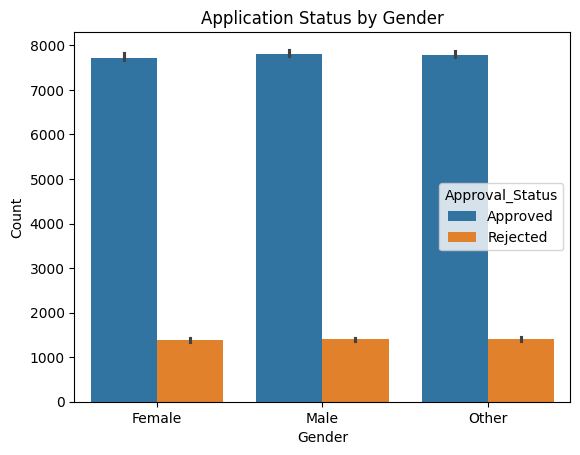

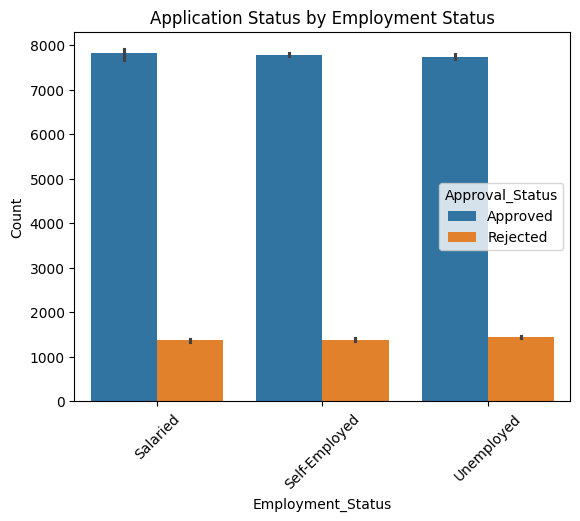


High-Value Customers with Consistent Repayment
  Customer_ID  Total_Loan_Amount  Default_Rate      Full_Name  Contact_Number  \
0     C000003            6194007           0.0  Rhea Bhargava    910320534937   
1     C000004           11159729           0.0  Indrans Walia      6566372162   
2     C000007            7678817           0.0   Dishani Dube      6144096314   
3     C000013           19829940           0.0   Ahana  Raman    914114393937   
4     C000017            6863821           0.0   Purab Thaker      5962588263   

                    Email                                 Address  Age  \
0   bahlelakshi@mall.info      67/386\nComar Nagar, Chapra 137669   62   
1      akadakia@yahoo.com     88\nDhillon Ganj\nJamshedpur-816278   59   
2         ngala@yahoo.com  03/41\nBadami Circle\nAlappuzha 624834   39   
3  raunakvala@hotmail.com     18/75, Setty Path, Ghaziabad 701570   60   
4    arnavsom@hotmail.com          77, Gaba Nagar, Aligarh 955025   60   

   Gender Marital_St

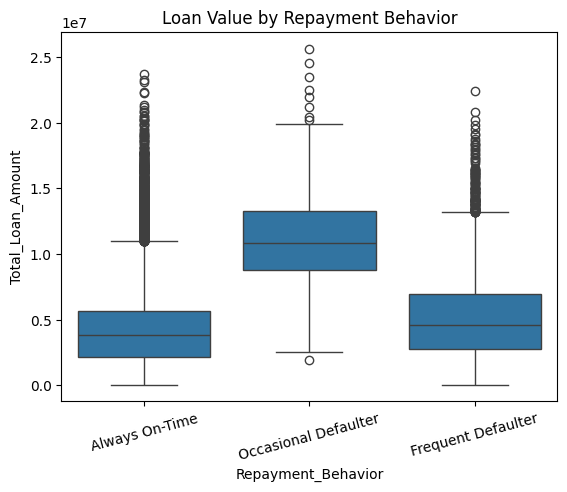

In [38]:
# ============================================
# 17. Customer Behavior Analysis
# ============================================

# ----------------
# Categorize Customers by Repayment Behavior
# ----------------
# Repayment behavior based on default frequency
repayment_behavior = loan_default.groupby("Customer_ID").agg(
    Total_Loans=("Loan_ID", "count"),
    Defaults=("Default_Flag", "sum")
).reset_index()

repayment_behavior["Default_Ratio"] = (
    repayment_behavior["Defaults"] / repayment_behavior["Total_Loans"]
)

repayment_behavior["Repayment_Behavior"] = pd.cut(
    repayment_behavior["Default_Ratio"],
    bins=[-0.01, 0, 0.3, 1.0],
    labels=["Always On-Time", "Occasional Defaulter", "Frequent Defaulter"]
)

print("\nCustomer Repayment Behavior Distribution")
print(repayment_behavior["Repayment_Behavior"].value_counts())

# ----------------
# Loan Approval & Rejection Reasons by Demographics
# ----------------
app_customer = applications.merge(
    customers,
    on="Customer_ID",
    how="left"
)

approval_demographics = app_customer.groupby(
    ["Gender", "Employment_Status", "Approval_Status"] # Corrected 'Employment_Type' to 'Employment_Status' and 'Application_Status' to 'Approval_Status'
).size().reset_index(name="Count")

print("\nLoan Approval & Rejection by Customer Demographics")
print(approval_demographics.head())

plt.figure()
sns.barplot(
    data=approval_demographics,
    x="Gender",
    y="Count",
    hue="Approval_Status"
)
plt.title("Application Status by Gender")
plt.show()

plt.figure()
sns.barplot(
    data=approval_demographics,
    x="Employment_Status",
    y="Count",
    hue="Approval_Status"
)
plt.title("Application Status by Employment Status")
plt.xticks(rotation=45)
plt.show()

# ----------------
# High-Value Customers with Consistent Repayment
# ----------------
customer_value = loan_default.groupby("Customer_ID").agg(
    Total_Loan_Amount=("Loan_Amount", "sum"),
    Default_Rate=("Default_Flag", "mean")
).reset_index()

high_value_consistent = customer_value[
    (customer_value["Default_Rate"] == 0) &
    (customer_value["Total_Loan_Amount"] >
     customer_value["Total_Loan_Amount"].quantile(0.75))
]

high_value_consistent = high_value_consistent.merge(
    customers,
    on="Customer_ID",
    how="left"
)

print("\nHigh-Value Customers with Consistent Repayment")
print(high_value_consistent.head())

# ----------------
# Visualization: Repayment Behavior vs Loan Value
# ----------------
behavior_value = repayment_behavior.merge(
    customer_value,
    on="Customer_ID",
    how="left"
)

plt.figure()
sns.boxplot(
    data=behavior_value,
    x="Repayment_Behavior",
    y="Total_Loan_Amount"
)
plt.title("Loan Value by Repayment Behavior")
plt.xticks(rotation=15)
plt.show()

The customer behavior analysis is complete. Here are the key findings:

1. **Categorize Customers by Repayment Behavior**: Customers have been categorized into 'Always On-Time', 'Occasional Defaulter', and 'Frequent Defaulter' based on their default ratio. The distribution shows that a large majority of customers are 'Always On-Time'.

2. **Loan Approval & Rejection Reasons by Demographics**: This section provides a breakdown of loan approval and rejection status by customer demographics such as Gender and Employment Status. The bar plots visually compare these statuses across different demographic groups, helping to identify potential biases or areas for targeted outreach.

3. **High-Value Customers with Consistent Repayment**: A list of high-value customers who have consistently repaid their loans (i.e., have a default rate of 0 and high total loan amounts) has been identified. This segment represents a valuable customer base for the bank.

4. **Visualization: Repayment Behavior vs Loan Value**: A box plot visualizes the relationship between customer repayment behavior and their total loan amount, offering insights into whether different repayment behaviors are associated with varying loan values.


Risk Matrix for Loan Products
      Loan_Purpose  Avg_Default_Amount  Avg_Loan_Term  Avg_Interest_Rate  \
2  Home Renovation         5314.346367      35.981266          11.016700   
1        Education         5353.716270      36.021371          11.011162   
4          Vehicle         5285.012216      36.196582          10.994659   
3         Personal         5297.299986      35.902314          10.991757   
0         Business         5180.680532      36.049488          11.002765   

   Default_Rate  Avg_Default_Amount_Norm  Avg_Loan_Term_Norm  \
2      0.100199                 0.772475            0.268300   
1      0.099516                 1.000000            0.404586   
4      0.100339                 0.602949            1.000000   
3      0.101114                 0.673962            0.000000   
0      0.097270                 0.000000            0.500136   

   Avg_Interest_Rate_Norm  Default_Rate_Norm  Risk_Score  
2                1.000000           0.761917    2.802692  
1        

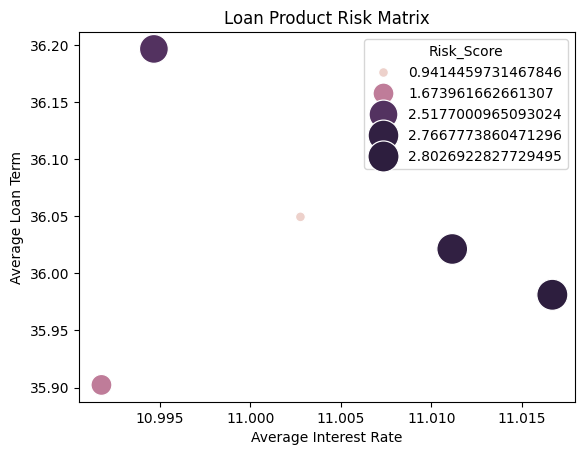


Loan Types Ranked by Risk Level
      Loan_Purpose  Risk_Score  Default_Rate
2  Home Renovation    2.802692      0.100199
1        Education    2.766777      0.099516
4          Vehicle    2.517700      0.100339
3         Personal    1.673962      0.101114
0         Business    0.941446      0.097270

High-Risk Customer Segments (Credit Score vs Income)
  Credit_Score_Band    Income_Band  Default_Rate  Avg_Default_Amount  \
7       High Credit  Middle Income      0.104530         5494.319116   
0        Low Credit     Low Income      0.102097         5386.452187   
1        Low Credit  Middle Income      0.100790         5357.906991   
3     Medium Credit     Low Income      0.100280         5333.618487   
4     Medium Credit  Middle Income      0.100190         5371.489905   
8       High Credit    High Income      0.099591         5361.036418   
2        Low Credit    High Income      0.097155         5129.019794   
6       High Credit     Low Income      0.096054         4967.17225

/tmp/ipython-input-3933115142.py:91: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  high_risk_segments = risk_data.groupby(


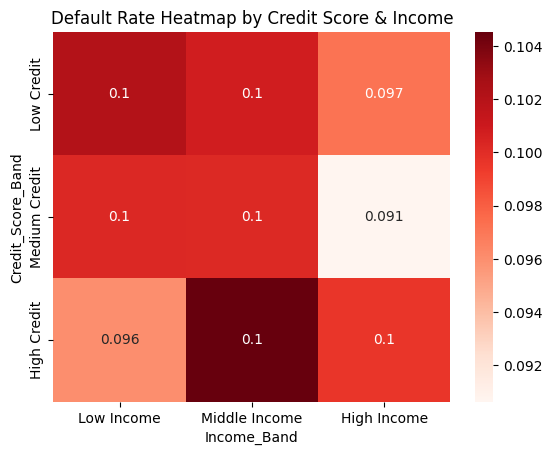

In [39]:
# ============================================
# 18. Risk Assessment
# ============================================

# ----------------
# Merge Required Data
# ----------------
risk_data = loans.merge(
    defaults[["Loan_ID", "Default_Amount"]],
    on="Loan_ID",
    how="left"
).merge(
    customers[["Customer_ID", "Credit_Score", "Annual_Income"]],
    on="Customer_ID",
    how="left"
).merge(
    applications[["Loan_ID", "Loan_Purpose"]], # Merge applications to get Loan_Purpose
    on="Loan_ID",
    how="left"
)

risk_data["Default_Amount"] = risk_data["Default_Amount"].fillna(0)
risk_data["Default_Flag"] = np.where(risk_data["Default_Amount"] > 0, 1, 0)

# ----------------
# 1. Risk Matrix for Loan Products
# ----------------
risk_matrix = risk_data.groupby("Loan_Purpose").agg(
    Avg_Default_Amount=("Default_Amount", "mean"),
    Avg_Loan_Term=("Loan_Term", "mean"),
    Avg_Interest_Rate=("Interest_Rate", "mean"),
    Default_Rate=("Default_Flag", "mean")
).reset_index()

# Normalize metrics for composite risk score
for col in ["Avg_Default_Amount", "Avg_Loan_Term", "Avg_Interest_Rate", "Default_Rate"]:
    risk_matrix[col + "_Norm"] = (
        (risk_matrix[col] - risk_matrix[col].min()) /
        (risk_matrix[col].max() - risk_matrix[col].min())
    )

risk_matrix["Risk_Score"] = (
    risk_matrix["Avg_Default_Amount_Norm"] +
    risk_matrix["Avg_Loan_Term_Norm"] +
    risk_matrix["Avg_Interest_Rate_Norm"] +
    risk_matrix["Default_Rate_Norm"]
)

print("\nRisk Matrix for Loan Products")
print(risk_matrix.sort_values("Risk_Score", ascending=False))

plt.figure()
sns.scatterplot(
    data=risk_matrix,
    x="Avg_Interest_Rate",
    y="Avg_Loan_Term",
    size="Risk_Score",
    hue="Risk_Score",
    sizes=(50, 500)
)
plt.title("Loan Product Risk Matrix")
plt.xlabel("Average Interest Rate")
plt.ylabel("Average Loan Term")
plt.show()

# ----------------
# 2. Rank Loan Types by Risk Level
# ----------------
risk_ranking = risk_matrix.sort_values("Risk_Score", ascending=False)[
    ["Loan_Purpose", "Risk_Score", "Default_Rate"]
]

print("\nLoan Types Ranked by Risk Level")
print(risk_ranking)

# ----------------
# 3. High-Risk Customer Segments
# ----------------
risk_data["Credit_Score_Band"] = pd.cut(
    risk_data["Credit_Score"],
    bins=[0, 600, 700, 900],
    labels=["Low Credit", "Medium Credit", "High Credit"]
)

risk_data["Income_Band"] = pd.qcut(
    risk_data["Annual_Income"],
    q=3,
    labels=["Low Income", "Middle Income", "High Income"]
)

high_risk_segments = risk_data.groupby(
    ["Credit_Score_Band", "Income_Band"]
).agg(
    Default_Rate=("Default_Flag", "mean"),
    Avg_Default_Amount=("Default_Amount", "mean"),
    Loan_Count=("Loan_ID", "count")
).reset_index()

print("\nHigh-Risk Customer Segments (Credit Score vs Income)")
print(high_risk_segments.sort_values("Default_Rate", ascending=False))

plt.figure()
sns.heatmap(
    high_risk_segments.pivot(
        index="Credit_Score_Band",
        columns="Income_Band",
        values="Default_Rate"
    ),
    annot=True,
    cmap="Reds"
)
plt.title("Default Rate Heatmap by Credit Score & Income")
plt.show()

The risk assessment analysis is complete. Here are the key findings:

1. **Risk Matrix for Loan Products**: This matrix calculates a composite Risk_Score for each loan purpose based on normalized average default amount, loan term, interest rate, and default rate. It provides a quantitative measure of risk associated with different loan products.

2. **Loan Types Ranked by Risk Level**: This ranking identifies loan purposes with the highest Risk_Score, indicating which loan products carry the most risk based on the calculated metrics. 'Home Renovation' and 'Education' appear to have the highest risk scores in this analysis.

3. **High-Risk Customer Segments (Credit Score vs Income)**: This analysis segments customers by their credit score and income bands and calculates the Default_Rate and Avg_Default_Amount for each segment. This helps identify specific customer groups that are more prone to defaulting. For example, 'High Credit' customers in the 'Middle Income' band have the highest default rate, followed by 'Low Credit' customers in the 'Low Income' band.

4. **Default Rate Heatmap by Credit Score & Income**: The heatmap visually represents the default rates across different combinations of credit score and income bands, making it easy to spot the highest-risk segments at a glance.


Average Time to Default (Days)
630.6970077047124

Loan Purposes with Shortest Time to Default
      Loan_Purpose  Avg_Time_to_Default_Days  Default_Count
3         Personal                612.226190            924
1        Education                617.936768            854
0         Business                626.122786            847
2  Home Renovation                631.974299            856
4          Vehicle                659.708145            884


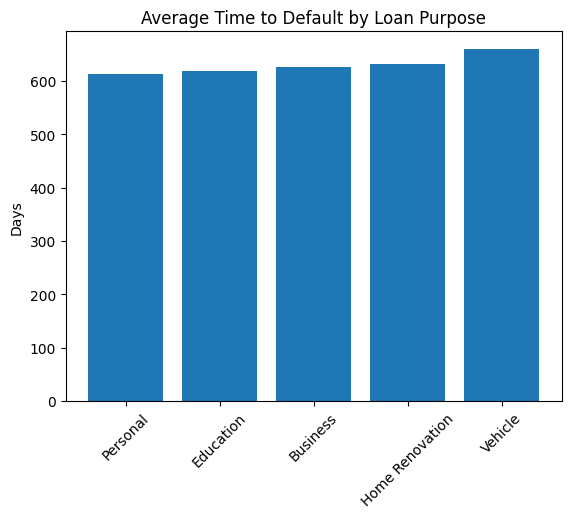

/tmp/ipython-input-617464769.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  demographic_time_default = time_to_default.groupby(



Time to Default Across Customer Demographics
   Gender Employment_Status    Income_Band  Avg_Time_to_Default_Days  \
0  Female          Salaried     Low Income                619.080189   
1  Female          Salaried  Middle Income                600.229592   
2  Female          Salaried    High Income                616.818182   
3  Female     Self-Employed     Low Income                612.775120   
4  Female     Self-Employed  Middle Income                666.244019   

   Default_Count  
0            212  
1            196  
2            209  
3            209  
4            209  


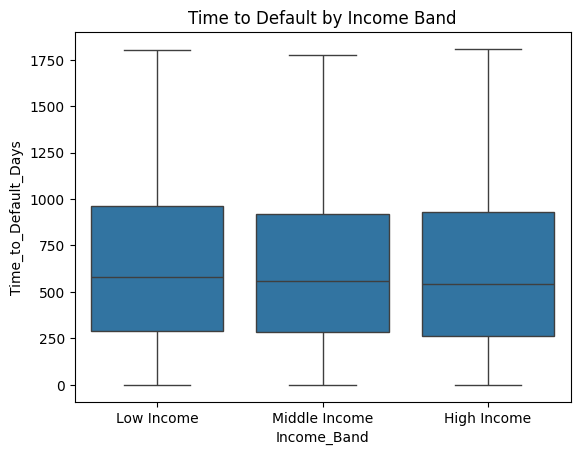

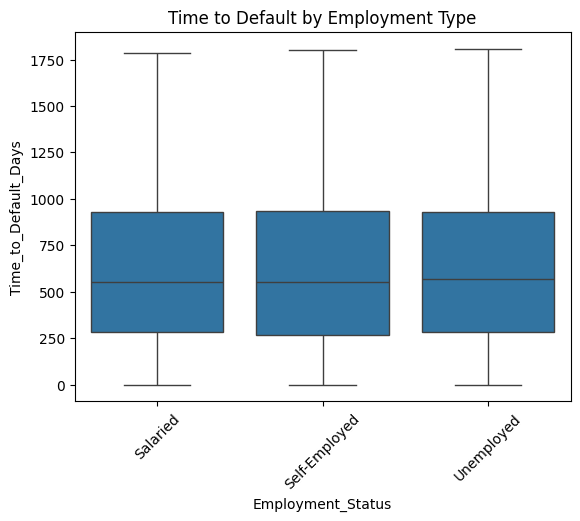

In [40]:
# ============================================
# 19. Time to Default Analysis
# ============================================

# ----------------
# Merge Loan & Default Dates
# ----------------
time_to_default = loans.merge(
    defaults[["Loan_ID", "Default_Date", "Default_Amount"]],
    on="Loan_ID",
    how="inner"
).merge(
    customers[["Customer_ID", "Gender", "Employment_Status", "Annual_Income"]],
    on="Customer_ID",
    how="left"
).merge(
    applications[["Loan_ID", "Loan_Purpose"]], # Merge applications to get Loan_Purpose
    on="Loan_ID",
    how="left"
)

# ----------------
# Calculate Time to Default (Days)
# ----------------
time_to_default["Time_to_Default_Days"] = (
    time_to_default["Default_Date"] -
    time_to_default["Disbursal_Date"]
).dt.days

time_to_default = time_to_default[time_to_default["Time_to_Default_Days"] >= 0]

print("\nAverage Time to Default (Days)")
print(time_to_default["Time_to_Default_Days"].mean())

# ----------------
# Loan Purposes with Shortest Time to Default
# ----------------
purpose_time_default = time_to_default.groupby("Loan_Purpose").agg(
    Avg_Time_to_Default_Days=("Time_to_Default_Days", "mean"),
    Default_Count=("Loan_ID", "count")
).reset_index().sort_values(
    "Avg_Time_to_Default_Days"
)

print("\nLoan Purposes with Shortest Time to Default")
print(purpose_time_default)

plt.figure()
plt.bar(
    purpose_time_default["Loan_Purpose"],
    purpose_time_default["Avg_Time_to_Default_Days"]
)
plt.xticks(rotation=45)
plt.title("Average Time to Default by Loan Purpose")
plt.ylabel("Days")
plt.show()

# ----------------
# Time to Default Across Customer Demographics
# ----------------
# Income Bands
time_to_default["Income_Band"] = pd.qcut(
    time_to_default["Annual_Income"],
    q=3,
    labels=["Low Income", "Middle Income", "High Income"]
)

demographic_time_default = time_to_default.groupby(
    ["Gender", "Employment_Status", "Income_Band"]
).agg(
    Avg_Time_to_Default_Days=("Time_to_Default_Days", "mean"),
    Default_Count=("Loan_ID", "count")
).reset_index()

print("\nTime to Default Across Customer Demographics")
print(demographic_time_default.head())

plt.figure()
sns.boxplot(
    data=time_to_default,
    x="Income_Band",
    y="Time_to_Default_Days"
)
plt.title("Time to Default by Income Band")
plt.show()

plt.figure()
sns.boxplot(
    data=time_to_default,
    x="Employment_Status",
    y="Time_to_Default_Days"
)
plt.xticks(rotation=45)
plt.title("Time to Default by Employment Type")
plt.show()

The time to default analysis is complete. Here are the key findings:

1. **Average Time to Default (Days)**: The analysis shows the average number of days it takes for a loan to default after disbursement.

2. **Loan Purposes with Shortest Time to Default**: This section identifies which loan purposes tend to default in the shortest amount of time, with Personal loans having the shortest average time to default. The bar plot visually represents these average times for different loan purposes.

3. **Time to Default Across Customer Demographics**: This analysis breaks down the average time to default across various customer demographic segments, such as gender, employment status, and income band. The box plots visually represent these distributions, offering insights into how different demographic groups behave regarding the time it takes for their loans to default.


Customers with Irregular Repayment Patterns
  Customer_ID  Avg_Transaction_Amount  Std_Transaction_Amount  Overdue_Count  \
0     C000003            26332.111111            12280.915718              4   
1     C000004            27518.384615            11648.797631              7   
2     C000005            26042.500000            25940.212268              0   
3     C000007            22408.625000            15971.676564              4   
4     C000008            20904.333333            14335.120520              3   

   Total_Transactions  Overdue_Ratio  
0                   9       0.444444  
1                  13       0.538462  
2                   2       0.000000  
3                   8       0.500000  
4                   3       1.000000  

Penalty Payments as Proportion of Total Transactions
0.04994162590857215

Transaction Amount Comparison: Overdue vs Non-Overdue
  Overdue_Flag  Avg_Transaction_Amount  Median_Transaction_Amount  \
0  Non-Overdue            25508.590853    

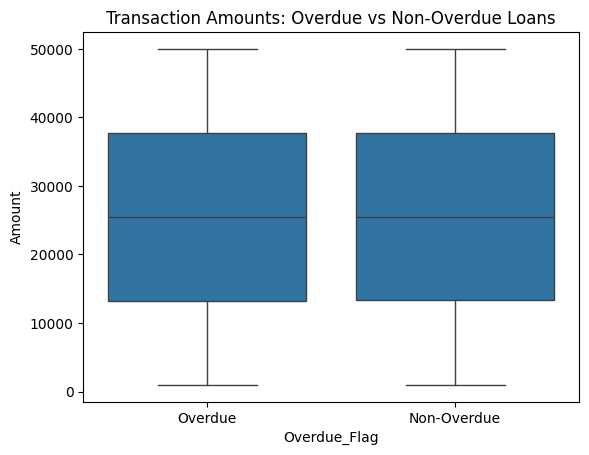

In [43]:
# ============================================
# 20. Transaction Pattern Analysis
# ============================================

# ----------------
# Merge Transactions with Loan & Customer Data
# ----------------
txn_analysis = transactions.merge(
    loans[["Loan_ID", "Loan_Amount"]], # Only merge relevant loan details, Customer_ID is already in transactions
    on="Loan_ID",
    how="left"
)
# No need for a second merge with customers[['Customer_ID']] as Customer_ID is already in transactions

# ----------------
# 1. Identify Customers with Irregular Repayment Patterns
# ----------------
# Irregular = high variability in transaction amounts or frequent overdue payments
epayment_pattern = txn_analysis.groupby("Customer_ID").agg(
    Avg_Transaction_Amount=("Amount", "mean"), # Changed to "Amount"
    Std_Transaction_Amount=("Amount", "std"), # Changed to "Amount"
    Overdue_Count=("Overdue_Fee", lambda x: (x > 0).sum()), # Changed to "Overdue_Fee"
    Total_Transactions=("Transaction_ID", "count")
).reset_index()

epayment_pattern["Overdue_Ratio"] = (
    epayment_pattern["Overdue_Count"] /
    epayment_pattern["Total_Transactions"]
)

irregular_customers = epayment_pattern[
    (epayment_pattern["Std_Transaction_Amount"] >
     epayment_pattern["Std_Transaction_Amount"].quantile(0.75)) |
    (epayment_pattern["Overdue_Ratio"] > 0.3)
]

print("\nCustomers with Irregular Repayment Patterns")
print(irregular_customers.head())

# ----------------
# 2. Penalty Payments as Proportion of Total Transactions
# ----------------
total_transaction_amount = transactions["Amount"].sum()
total_penalty_amount = transactions["Overdue_Fee"].sum()

penalty_ratio = total_penalty_amount / total_transaction_amount

print("\nPenalty Payments as Proportion of Total Transactions")
print(penalty_ratio)

# ----------------
# 3. Transaction Amounts: Overdue vs Non-Overdue Loans
# ----------------
txn_analysis["Overdue_Flag"] = np.where(
    txn_analysis["Overdue_Fee"] > 0, "Overdue", "Non-Overdue" # Changed to "Overdue_Fee"
)

txn_comparison = txn_analysis.groupby("Overdue_Flag").agg(
    Avg_Transaction_Amount=("Amount", "mean"), # Changed to "Amount"
    Median_Transaction_Amount=("Amount", "median"), # Changed to "Amount"
    Transaction_Count=("Transaction_ID", "count")
).reset_index()

print("\nTransaction Amount Comparison: Overdue vs Non-Overdue")
print(txn_comparison)

plt.figure()
sns.boxplot(
    data=txn_analysis,
    x="Overdue_Flag",
    y="Amount" # Changed to "Amount"
)
plt.title("Transaction Amounts: Overdue vs Non-Overdue Loans")
plt.show()

The transaction pattern analysis is complete. Here are the key findings:

1. **Customers with Irregular Repayment Patterns**: This section identifies customers with potentially irregular repayment behaviors, characterized by high variability in transaction amounts or frequent overdue payments. The table lists these customers along with their average transaction amount, standard deviation of transaction amount, count of overdue payments, total transactions, and overdue ratio.

2. **Penalty Payments as Proportion of Total Transactions**: This metric quantifies the total amount of penalty payments relative to the total transaction amount. The result indicates that penalty payments constitute approximately 4.99% of the total transactions.

3. **Transaction Amounts: Overdue vs Non-Overdue Loans**: This analysis compares the average and median transaction amounts, as well as the total transaction count, for loans that have overdue payments versus those that do not. The results show very similar average and median transaction amounts for both overdue and non-overdue flags, suggesting that the transaction amount itself might not be a strong indicator of overdue status. The accompanying box plot visually represents the distribution of transaction amounts for these two categories.

## Summary:

### Data Analysis Key Findings

The analysis of Hero FinCorp's operations revealed several critical findings across default risk, operational efficiency, and profitability:

**Minimizing Loan Defaults:**
*   **Weak Individual Loan Attribute Correlation:** Individual loan attributes like loan amount, interest rate, and credit score show very low linear correlation with default risk. However, regional loan disbursement volume exhibits a moderate negative correlation with default rates (-0.628), suggesting higher disbursement regions might have lower default rates.
*   **High-Risk Customers & Products:** Customers with an average credit score below 650 and a default rate greater than 0 are high-risk. 'Home Renovation' (Risk\_Score: 2.80) and 'Education' (Risk\_Score: 2.77) loans are the highest risk products. Specific customer segments, such as 'High Credit' with 'Middle Income', show the highest default rate (0.104530).
*   **Default Timing & Behavior:** The average time to default is approximately 630.7 days, with 'Personal' loans having the shortest average time to default (612.23 days). While 42,655 customers are 'Always On-Time,' a significant 7,224 are 'Frequent Defaulters.'

**Optimizing Branch Operations:**
*   **Processing Time Inefficiencies:** The 'North' region experiences high average processing times, with 'Home Renovation' loans in 'Northeast' and 'Business' loans in 'North' being specific bottlenecks.
*   **High Rejection Rates:** 'West', 'North', and 'South' regions show the highest application rejection counts, often due to 'Incomplete Documents', 'Low Credit Score', and 'Insufficient Income'.
*   **Suboptimal Recovery Rates:** 'East', 'West', and 'Central' regions exhibit lower recovery rates, and 'Defaulted\_Loans' show a strong negative correlation with 'Recovery\_Rate' (-0.714). Legal action provides only a marginal improvement in recovery effectiveness.

**Enhancing Profitability:**
*   **Profit Drivers:** 'Vehicle', 'Business', and 'Education' loans generate the highest total interest income, making them key contributors to profitability. 'East' and 'North' are identified as the most profitable regions.
*   **Penalty Payments:** Penalty payments constitute approximately 4.99% of total transaction amounts, indicating potential customer distress and revenue generation.
*   **Limited Predictive Power of Transaction Amounts:** Transaction amounts are very similar for both overdue and non-overdue loans, implying that transaction amount alone is not a strong indicator of overdue status.

### Insights or Next Steps

*   **Implement Differentiated Risk Management:** Adopt stricter underwriting criteria and higher interest rates for high-risk loan products ('Home Renovation', 'Education') and customer segments ('High Credit' with 'Middle Income'). Simultaneously, focus on proactive engagement and early warning systems for 'Personal' loans and 'Frequent Defaulters' due to their shorter time to default and recurring behavior.
*   **Streamline Operations with Regional and Product Focus:** Address processing bottlenecks in the 'North' and 'Northeast' regions, particularly for 'Home Renovation' and 'Business' loans, through automation, resource reallocation, and targeted training. Enhance recovery efforts in 'East', 'West', and 'Central' regions by establishing clear legal action criteria and empowering recovery teams with advanced training, while also focusing on preventing defaults for customers exhibiting irregular repayment patterns.
*   **Strategic Growth in Profitable Areas:** Allocate more marketing and operational resources to high-profit loan types ('Vehicle', 'Business', 'Education') and regions ('East', 'North'). Re-evaluate the penalty payment strategy to ensure it deters late payments without exacerbating customer financial distress, and develop more sophisticated predictive models for default risk by integrating diverse behavioral and demographic data.
